# Analysis of Y2H combinatorial library of human-mouse STAT2 variants
With Matt Evans, Ethan Veit, Blake Richardson, et al. at Mount Sinai. 
Analysis by Caroline Kikawa.

## Background
STAT2 is an innate immune signaling protein that can be bound and signaled for degradation by flaviviral non-structural protein 5. Human STAT2 is vulnerable to this targeting by NS5, but murine (mouse) STAT2 is not. 

A yeast-2-hybrid (Y2H) library of STAT2 was created by the Evans lab. This library was designed to contain mutations in the 198-209 amino acid region of STAT2, where are all possible combinations of the 8 amino acid differences between human and mouse STAT2 were created. With 2^8 possible combinations, this results in 256 unique sequences. 

They selected for yeast that uptook expression plasmids with '2x' media. They also selected the same library with '4x+' media, which selected for expression plasmid uptake as well as binding by NS5. Here, I analyze the result of barcoded subamplicon sequencing these libraries. 

In [1]:
import os
import pandas as pd
import gzip
from Bio import SeqIO
from Bio.Seq import Seq
import re
import numpy as np
import altair as alt

import warnings
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
datadir = 'data'
resultsdir = 'results'

os.makedirs(datadir, exist_ok=True)
os.makedirs(resultsdir, exist_ok=True)

samplefile = os.path.join(datadir, 'samplelist.csv')

In [3]:
sample_df = pd.read_csv(samplefile)
sample_df['sample_id'] = sample_df['name'] + '_' + sample_df['condition']
sample_df

,name,condition,R1,sample_id
0,Library_1,2x,/shared/ngs/illumina/ckikawa/231115_M08474_006...,Library_1_2x
1,Library_1,4xplus,/shared/ngs/illumina/ckikawa/231115_M08474_006...,Library_1_4xplus
2,Library_2,2x,/shared/ngs/illumina/ckikawa/231115_M08474_006...,Library_2_2x
3,Library_2,4xplus,/shared/ngs/illumina/ckikawa/231115_M08474_006...,Library_2_4xplus


In [4]:
# identifier = 'CAG ACC AAA GAG CAG AAG'

upstream_identifier = 'GAC CCg  CAc CAa  ACg  AAg GAa CAa  AAG'  # from deep sequencing data
downstream_identifier = 'AGA AAG GAA GTC'

clean_upstream_identifier = (upstream_identifier.replace(' ', '')).upper()
clean_downstream_identifier = (downstream_identifier.replace(' ', '')).upper()
rc_clean_upstream_identifier = str(Seq(clean_upstream_identifier).reverse_complement())

print(clean_upstream_identifier, rc_clean_upstream_identifier)
print(clean_downstream_identifier)

GACCCGCACCAAACGAAGGAACAAAAG CTTTTGTTCCTTCGTTTGGTGCGGGTC
AGAAAGGAAGTC


In [5]:
countsdir = os.path.join(resultsdir, 'counts')
os.makedirs(countsdir, exist_ok=True)

for sample in sample_df['sample_id'].unique():
    print(sample_df.query(f'sample_id == "{sample}"').R1.values[0])
    
    # File path to FASTA file
    filepath = sample_df.query(f'sample_id == "{sample}"').R1.values[0]

    # Initialize temporary dictionary for storing mutagenized regions (keys) and their counts (values)
    temp_dict = {}

    # Open with mode 'rt' and gzip to handle fastq.gz files
    with gzip.open(filepath, mode='rt') as handle:

        # count = 0
        
        for record in SeqIO.parse(handle, 'fastq'):
    
            # Extract individual parts of the FASTA record
            identifier = record.id
            description = record.description
            sequence = record.seq
            sequence_string = str(sequence)

            # Tell me how many RC identifiers we have, but for now, ignore them
            if rc_clean_upstream_identifier in sequence:
                print('RC HONK')
                print(sequence)

            # Search the R1 strand for the upstream identifier sequence
            if re.search(clean_upstream_identifier, sequence_string):
                # Find index of match
                query_start = re.search(clean_upstream_identifier, sequence_string).start()
                query_end = re.search(clean_upstream_identifier, sequence_string).end()
                # Mutagenized region is directly 5' to match, and 36 N long
                mutagenized_region_start = query_end
                mutagenized_region_end = query_end + 36
                # Index sequence for mutagenized region
                mutagenized_region = sequence_string[mutagenized_region_start:mutagenized_region_end]

                # Also check downstream flanking sequence
                downstream_start = mutagenized_region_end
                downstream_end = mutagenized_region_end + len(clean_downstream_identifier)
                if clean_downstream_identifier == sequence_string[downstream_start:downstream_end]:
                    # Save new mutagenized regions with count 1
                    if mutagenized_region not in temp_dict.keys():
                        temp_dict[mutagenized_region] = 1
                    # If this is a previously seen mutagenized region, add 1 to count
                    elif mutagenized_region in temp_dict.keys():
                        temp_dict[mutagenized_region] += 1
    
                        # print(sequence_string)
                        # print(mutagenized_region)
                        # print(sequence_string[downstream_start:downstream_end])
                        # break

            # count += 1
            # if count == 1000:
            #     break
                
    # Save sample file
    outfile = os.path.join(countsdir, f'{sample}_counts.csv')
    with open(outfile, 'w') as f:
        f.write("%s,%s\n"%('sequence', 'count'))
        for key in temp_dict.keys():
            f.write("%s,%s\n"%(key,temp_dict[key]))
    

/shared/ngs/illumina/ckikawa/231115_M08474_0061_000000000-L5HJ4/Unaligned/Project_ckikawa/Library_1_2x_S4_R1_001.fastq.gz
RC HONK
TCTCCGCGCTTCCACTCCTCCAACTTTGGCAGCAGTAGCTCGATTAGGGTAGTTAATCTTCCCAAGAGAGCCTTTGAAGCATCCAGGACTTCATTTCTCATCTTGTCTACCTTATTAGCAGTTGCCTGTAGTAGCTTTTGTTCCTTCGTTTGGTGCGGGTCCAGAGAGGGTGTCTTCCCTTTGGCCTGGATCTTATATCGGAAGCAGAAGACATCCTGCTGGTCTTTCAGTTGGCTGATGGATTTTACGA
RC HONK
TTGGCGATCTTCCACTCCTCCAACTTTGGCAGCAGTAGCTCGATTAGGGTAGTTAATCTTCCCAAGAGAGCCTTTGAAGCATCCAGGACTTCCTTTCTCCTCTTGTCTACCTTATTAGCAGTCTCCTGAACGATCTTTTGTTCCTTCGTTTGGTGCGGGTCCAGAGAGGGCGTCTTCCCTTTGGCCTGGATCTTATATCGGAAGCAGAAGACATCCTGCTGGTCTTTCAGTTGGCTGATGGATTTTACGA
RC HONK
GGGGCCGGCTTCCACTCCTCCAACTTTGGCAGCAGTAGCTCGATTAGGGTAGTTAATCTTCCCAAGAGATCCTTTGAAGCATCCAGGACTTCCTTTCTCATCTTGTCAAGCTTATTAGCAGTTGCCTGTAGTAGCTTTTGTTCCTTCGTTTGGTGCGGGTCCAGAGAGGGTGTCTTCCCTTTGGCCTGGATCTTATATCGGAAGCAGAAGACATCCTGCTGGTCTTTCAGTTGGCTGATGGATTTTACGA
RC HONK
CTCTTCGGCTTCCACTCCTCCAACTTTGGCAGCAGTAGCTCGATTAGGGTAGTTAATCTTCCCAAGAGATCCTTTGAAGCATCCAGGACTTCC

In [6]:
# Expected sequences, extracted from Excel spreadsheet from Matt
possible_sequences_file = os.path.join(datadir, 'all_possible_198-209_sequences.csv')

# Populate list with expected sequences
possible_sequences_list = []
with open(possible_sequences_file, mode = 'r') as f:
    for item in f:
        tidy_item = item.strip('\n').strip('\ufeff').upper()
        possible_sequences_list.append(tidy_item)

# Make directories for expected sequence counts and unexpected (noise) sequence counts
expected_countsdir = os.path.join(resultsdir, 'counts_expected')
noise_countsdir = os.path.join(resultsdir, 'counts_noise')
os.makedirs(expected_countsdir, exist_ok=True)
os.makedirs(noise_countsdir, exist_ok=True)

# Initialize empty list for expected and noise counts
expected_and_noise_counts = []

# Write counts directories for expected and noise
# I.e., check each mutagenized region sequence and see if it's in the expected sequence list
for sample in sample_df['sample_id'].unique():
    file = os.path.join(countsdir, f'{sample}_counts.csv')
    df = pd.read_csv(file)
    
    # print(file)
    # print(len(df))

    temp_expected_list = []
    temp_noise_list = []

    for line in df.iterrows():
        sequence = line[1]['sequence']
        count = line[1]['count']
        
        if sequence in possible_sequences_list:
            temp_expected_list.append([sequence, count])
            
        elif sequence not in possible_sequences_list:
            temp_noise_list.append([sequence, count])

    # Save expected counts 
    outfile = os.path.join(expected_countsdir, f'{sample}_counts.csv')
    with open(outfile, 'w') as f:
        f.write("%s,%s\n"%('sequence', 'count'))
        for item in temp_expected_list:
            f.write("%s,%s\n"%(item[0], item[1]))
    
    # Save noise counts 
    outfile = os.path.join(noise_countsdir, f'{sample}_counts.csv')
    with open(outfile, 'w') as f:
        f.write("%s,%s\n"%('sequence', 'count'))
        for item in temp_noise_list:
            f.write("%s,%s\n"%(item[0], item[1]))            

    # Some read stats
    # print('here is the number of expected sequences detected (out of 256)...', len(temp_expected_list))
    # print('here is the number of unique noise sequences detected...', len(temp_noise_list))

    expected_df = pd.DataFrame(temp_expected_list, columns = ['sequence', 'counts'])
    noise_df = pd.DataFrame(temp_noise_list, columns = ['sequence', 'counts'])

    # print('here is the total expected counts...', expected_df['counts'].sum())
    # print('here is the total noise counts...', noise_df['counts'].sum())

    expected_and_noise_counts.append([sample, 
                                      expected_df['counts'].sum(),
                                      noise_df['counts'].sum()])

expected_and_noise_counts_df = (pd.DataFrame(expected_and_noise_counts, 
                                            columns = ['name', 'expected_counts', 'noise_counts'])
                                .set_index(['name'])
                               )
outfile = os.path.join(countsdir, 'expected_and_noise_counts.csv')
expected_and_noise_counts_df.to_csv(outfile, index=False)
expected_and_noise_counts_df

,expected_counts,noise_counts
name,,
Library_1_2x,533789,28453
Library_1_4xplus,617190,30809
Library_2_2x,739891,37263
Library_2_4xplus,840117,40690


In [7]:
# Now analyze the fold-change for each library from 2x to 4x+
# Calculate the mean fold-change across libraries

fcdir = os.path.join(resultsdir, 'fc')
os.makedirs(fcdir, exist_ok=True)

sample_withCount_df = sample_df
sample_withCount_df = (sample_withCount_df
                       .assign(expected_counts = lambda x: 'results/counts_expected/' + x['sample_id'] + '_counts.csv')
                      )

tidy_sample_withCount_df = (sample_withCount_df
                            .pivot(index='name', columns ='condition', values = 'expected_counts')
                            .reset_index()
                           )
tidy_sample_withCount_df

condition,name,2x,4xplus
0,Library_1,results/counts_expected/Library_1_2x_counts.csv,results/counts_expected/Library_1_4xplus_count...
1,Library_2,results/counts_expected/Library_2_2x_counts.csv,results/counts_expected/Library_2_4xplus_count...


In [8]:
# Calculate fold-change for each library
for lib in tidy_sample_withCount_df.name:

    # Subset initial (2x) and selected (4x) frequencies
    initial_freq_df = pd.read_csv(tidy_sample_withCount_df.query(f'name == "{lib}"')['2x'].values[0])
    selected_freq_df = pd.read_csv(tidy_sample_withCount_df.query(f'name == "{lib}"')['4xplus'].values[0])
    
    merged_freq_df = (initial_freq_df
                      .merge(selected_freq_df, on = 'sequence', suffixes= ['_2x','_4xplus'])
                     )

    # Calculate fold-change and log fold-change
    merged_freq_df['FC'] = merged_freq_df['count_4xplus'] / merged_freq_df['count_2x']
    merged_freq_df['logFC'] = np.log(merged_freq_df['FC'])

    # Save these individiually 
    outfile = os.path.join(fcdir, f'{lib}_fold-change.csv')
    merged_freq_df.to_csv(outfile, index=False)


# Write mean fold-change across libraries
lib_1_fc = pd.read_csv(os.path.join(fcdir, 'Library_1_fold-change.csv'))
lib_2_fc = pd.read_csv(os.path.join(fcdir, 'Library_2_fold-change.csv'))
mean_df = lib_1_fc.merge(lib_2_fc, on = ['sequence'], suffixes = ['_lib1', '_lib2'])
mean_df['mean_FC'] = mean_df[['FC_lib1', 'FC_lib2']].mean(axis=1)
mean_df['mean_logFC'] = mean_df[['logFC_lib1', 'logFC_lib2']].mean(axis=1)

# Save summary 
outfile = os.path.join(fcdir, 'summary_fold-change.csv')
mean_df.to_csv(outfile, index=False)
mean_df

,sequence,count_2x_lib1,count_4xplus_lib1,FC_lib1,logFC_lib1,count_2x_lib2,count_4xplus_lib2,FC_lib2,logFC_lib2,mean_FC,mean_logFC
0,ATCGTTCAGGCAACTGCTAATAAGGTAGACAGAAGG,1566,394,0.251596,-1.379929,3987,526,0.131929,-2.025493,0.191763,-1.702711
1,CTACTACAGGAGACTGCTAATAAGGTAGACAAGATG,2430,1865,0.767490,-0.264630,2470,24197,9.796356,2.282011,5.281923,1.008690
2,CTACTACAGGCAACTGCTAATAAGGTAGACAGAAGG,13639,591,0.043332,-3.138873,14430,771,0.053430,-2.929376,0.048381,-3.034124
3,CTAGTTCAGGCAACTGCTAATAAGCTTGACAGAAGG,6692,663,0.099074,-2.311893,5133,866,0.168712,-1.779561,0.133893,-2.045727
4,CTACTACAGGCAACTCTGAATAAGCTTGACAGAATG,886,567,0.639955,-0.446358,3796,404,0.106428,-2.240288,0.373191,-1.343323
...,...,...,...,...,...,...,...,...,...,...,...
251,ATCCTACAGGAGACTCTGAATAAGCTTGACAAGAGG,342,246,0.719298,-0.329479,186,927,4.983871,1.606207,2.851585,0.638364
252,CTACTACAGGAGACTCTGAATAAGGTAGACAAGAGG,297,695,2.340067,0.850180,265,476,1.796226,0.585688,2.068147,0.717934
253,CTACTACAGGAGACTCTGAATGAGGTAGACAGAATG,316,365,1.155063,0.144155,142,764,5.380282,1.682741,3.267672,0.913448
254,CTAGTTCAGGAGACTCTGAATGAGGTAGACAAGAGG,401,998,2.488778,0.911792,432,541,1.252315,0.224994,1.870546,0.568393


## Plot some basic quality checks

In [9]:
# Seaborn style settings
sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
sns.set_style("ticks")
sns.set_palette("Set1")

In [10]:
plotsdir = os.path.join(resultsdir, 'plots')
os.makedirs(plotsdir, exist_ok = True)

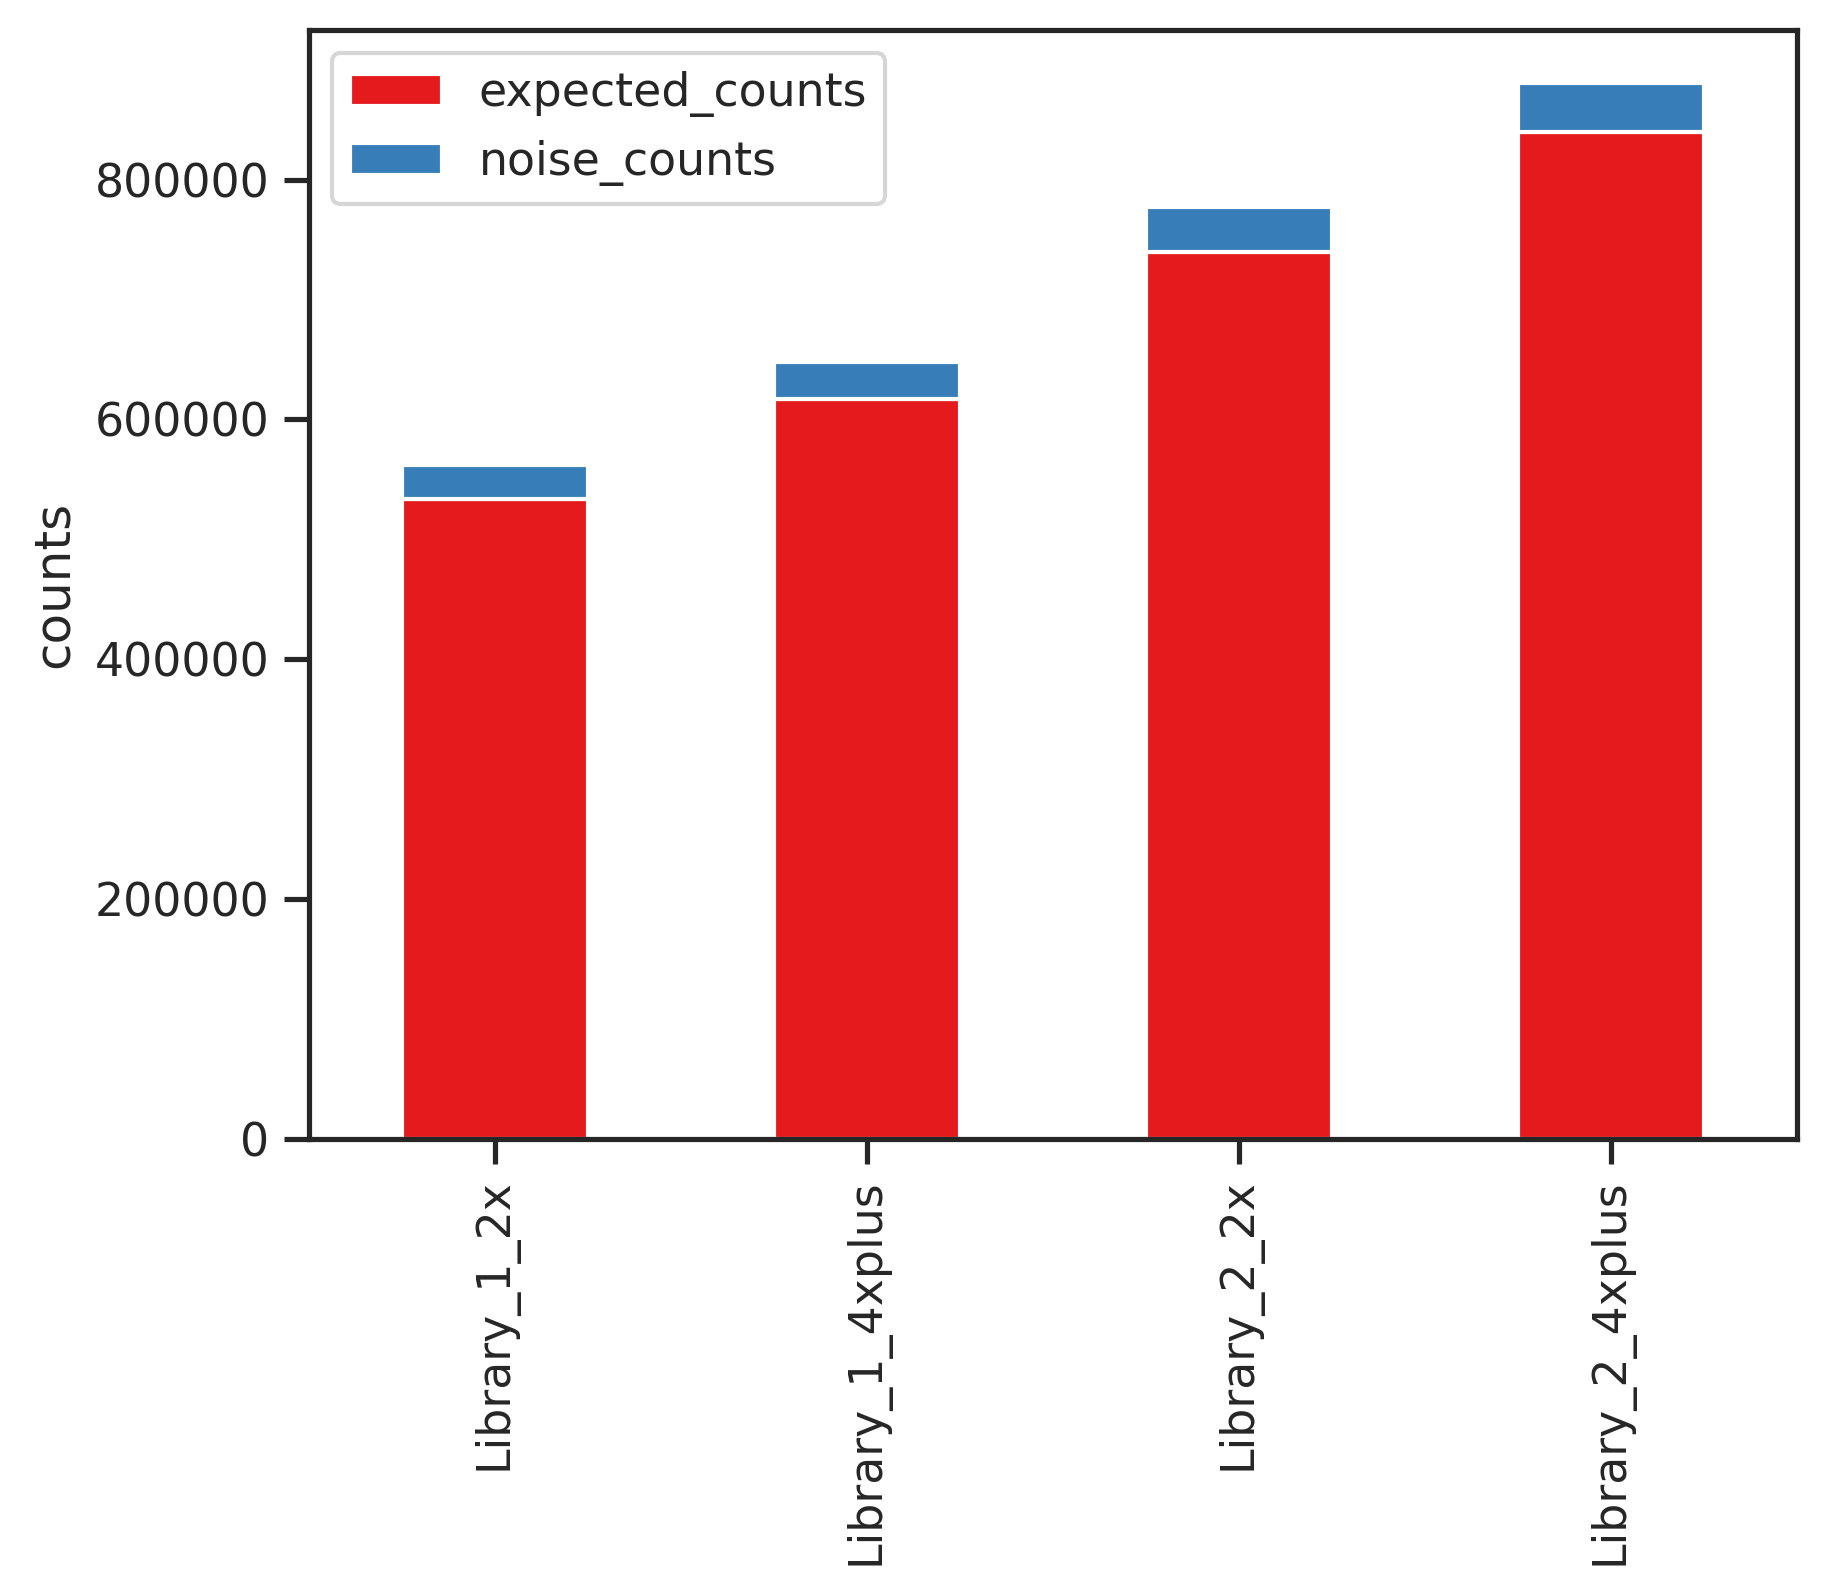

In [11]:
# Plot expected vs noise counts
expected_and_noise_counts_df.plot(kind='bar', 
                                  stacked=True, 
                                  # color=['red', 'skyblue', 'green']
                                 )
# labels for x & y axis
plt.xlabel('')
plt.ylabel('counts')

# title of plot
plt.title('')

# Save plot
outfile = os.path.join(plotsdir, 'mutated_region_counts.png')
plt.savefig(outfile, dpi = 'figure')

R=0.5347667511902643
R^2=0.28597547817859004


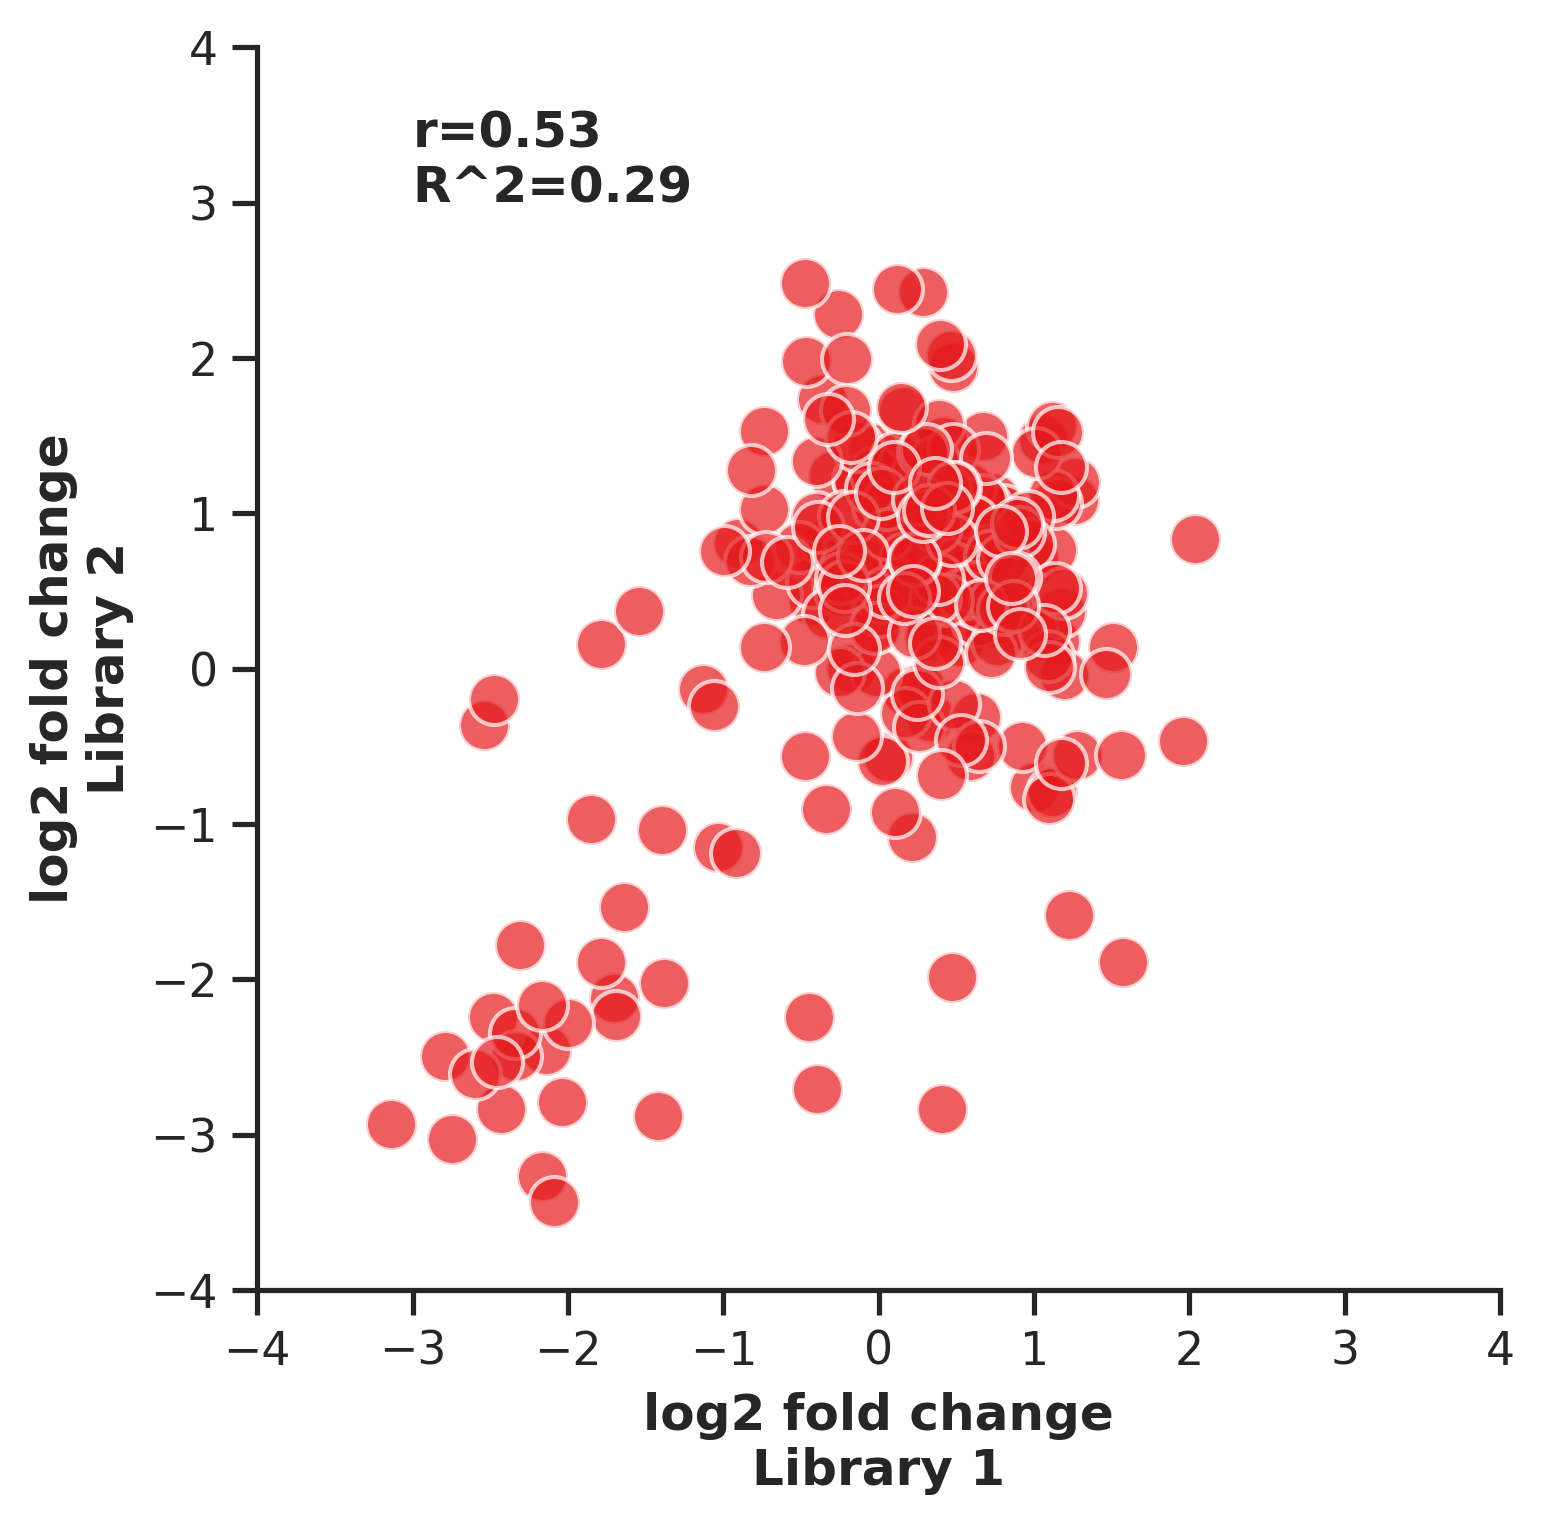

In [12]:
# Correlation between libraries 

# Calculate correlation between predicted and measured
r, p = sp.stats.pearsonr(
    x = mean_df['logFC_lib1'], 
    y = mean_df['logFC_lib2']
)
print(f"R={r}")
print(f"R^2={r**2}")

# Plot predicted vs measured
corr_chart = sns.relplot(
    data = mean_df,
    x = "logFC_lib1", 
    y = "logFC_lib2",
    markers = ["o", "s"],
    aspect = 1.25,
    s = 150,
    alpha = 0.7,
    kind = "scatter",
)
corr_chart.axes[0,0].set_xlabel(
    "log2 fold change\nLibrary 1", 
    weight="bold"
)
corr_chart.axes[0,0].set_ylabel(
    "log2 fold change\nLibrary 2", 
    weight="bold"
)
corr_chart.axes[0,0].set_xlim(-4, 4)
corr_chart.axes[0,0].set_ylim(-4, 4)
corr_chart.axes[0,0].text(
    -3, 
    3, 
    f"r={r:.2f}\nR^2={r**2:.2f}", 
    horizontalalignment="left",  
    weight="bold",
    fontsize=12,
)

# Set square ratio
corr_chart.axes[0,0].set_box_aspect(1)

# Save plot
outfile = os.path.join(plotsdir, 'expected_vs_noise_corr.png')
plt.savefig(outfile, dpi = 'figure')

In [13]:
mean_translated_df = (mean_df
                      .rename(columns = {'sequence': 'nc_seq'})
                     )
mean_translated_df['prot_seq'] = mean_translated_df['nc_seq'].apply(lambda x: ''.join(Seq(x).translate()))

# want a column of mouse mutations relative to human
# this should be stored in resi notation as separate strings
# also include column of count of mouse muts (relative to human)

# generate list of human residues
hu_protein = 'ILQETLNELDKR'
hu_protein_list = [*hu_protein]
hu_protein_resi_list = []
i = 198
for res in hu_protein_list:
    resi = str(i) + res
    hu_protein_resi_list.append(resi)
    i += 1


# initialize empty list for protein seq, resi protein seq, mutations relative to human, mutation count
mouse_mutations = []
# iterate through protein sequences and populate list 
for protein in mean_translated_df.prot_seq.unique():
    # make list of mutations in resi format
    protein_list = [*protein]
    protein_resi_list = []
    i = 198
    for res in protein_list:
        resi = str(i) + res
        protein_resi_list.append(resi)
        i += 1

    # generate list of mouse mutations relative to human
    mouse_aa_muts_list = list(sorted(set(protein_resi_list).difference(hu_protein_resi_list)))
    # count the mouse mutations relative to human
    count_mouse_muts = (len(mouse_aa_muts_list))

    mouse_mutations.append([protein, protein_resi_list, mouse_aa_muts_list, count_mouse_muts])

# produce dataframe of mouse mutaitons
mouse_mutations_df = pd.DataFrame(mouse_mutations, columns = ['prot_seq', 'resi_prot_seq', 'mouse_muts', 'count_mouse_muts'])
# add human sequence
mean_translated_df['human_prot_seq'] = hu_protein

# merge mouse mutation dataframe and mean df
merged_df = mean_translated_df.merge(mouse_mutations_df, on = 'prot_seq')

# contains individual mouse mutations or not?
mouse_muts = ['198L', '199V', '201A', '203A', 
              '205K', '206V', '208R', '209M']
for mut in mouse_muts:
    merged_df[f'contains_{mut}'] = merged_df.mouse_muts.map(set([f'{mut}']).issubset)

# We also want the standard deviation of the logFC values calculated from library 1 and 2
merged_df['std'] = merged_df[['logFC_lib1','logFC_lib2']].std(axis = 1)

# Tell us a bit about those values
print('here is some information on the standard deviation of logFC values calculated from replicate libraries...')
print(merged_df[['std']].describe())

# Now show some dataframe
print('and here is a preview of all the data...')
merged_df.head()

here is some information on the standard deviation of logFC values calculated from replicate libraries...
              std
count  256.000000
mean     0.590528
std      0.479008
min      0.000788
25%      0.215479
50%      0.491509
75%      0.831485
max      2.448084
and here is a preview of all the data...


,nc_seq,count_2x_lib1,count_4xplus_lib1,FC_lib1,logFC_lib1,count_2x_lib2,count_4xplus_lib2,FC_lib2,logFC_lib2,mean_FC,...,count_mouse_muts,contains_198L,contains_199V,contains_201A,contains_203A,contains_205K,contains_206V,contains_208R,contains_209M,std
0,ATCGTTCAGGCAACTGCTAATAAGGTAGACAGAAGG,1566,394,0.251596,-1.379929,3987,526,0.131929,-2.025493,0.191763,...,6,False,True,True,True,True,True,True,False,0.456483
1,CTACTACAGGAGACTGCTAATAAGGTAGACAAGATG,2430,1865,0.767490,-0.264630,2470,24197,9.796356,2.282011,5.281923,...,5,True,False,False,True,True,True,False,True,1.800747
2,CTACTACAGGCAACTGCTAATAAGGTAGACAGAAGG,13639,591,0.043332,-3.138873,14430,771,0.053430,-2.929376,0.048381,...,6,True,False,True,True,True,True,True,False,0.148136
3,CTAGTTCAGGCAACTGCTAATAAGCTTGACAGAAGG,6692,663,0.099074,-2.311893,5133,866,0.168712,-1.779561,0.133893,...,6,True,True,True,True,True,False,True,False,0.376416
4,CTACTACAGGCAACTCTGAATAAGCTTGACAGAATG,886,567,0.639955,-0.446358,3796,404,0.106428,-2.240288,0.373191,...,5,True,False,True,False,True,False,True,True,1.268501


## Produce visualizations
Matt and team want a combination of static and interactive plots. I'll produce some here and get feedback on what is helpful/needs refinement. 

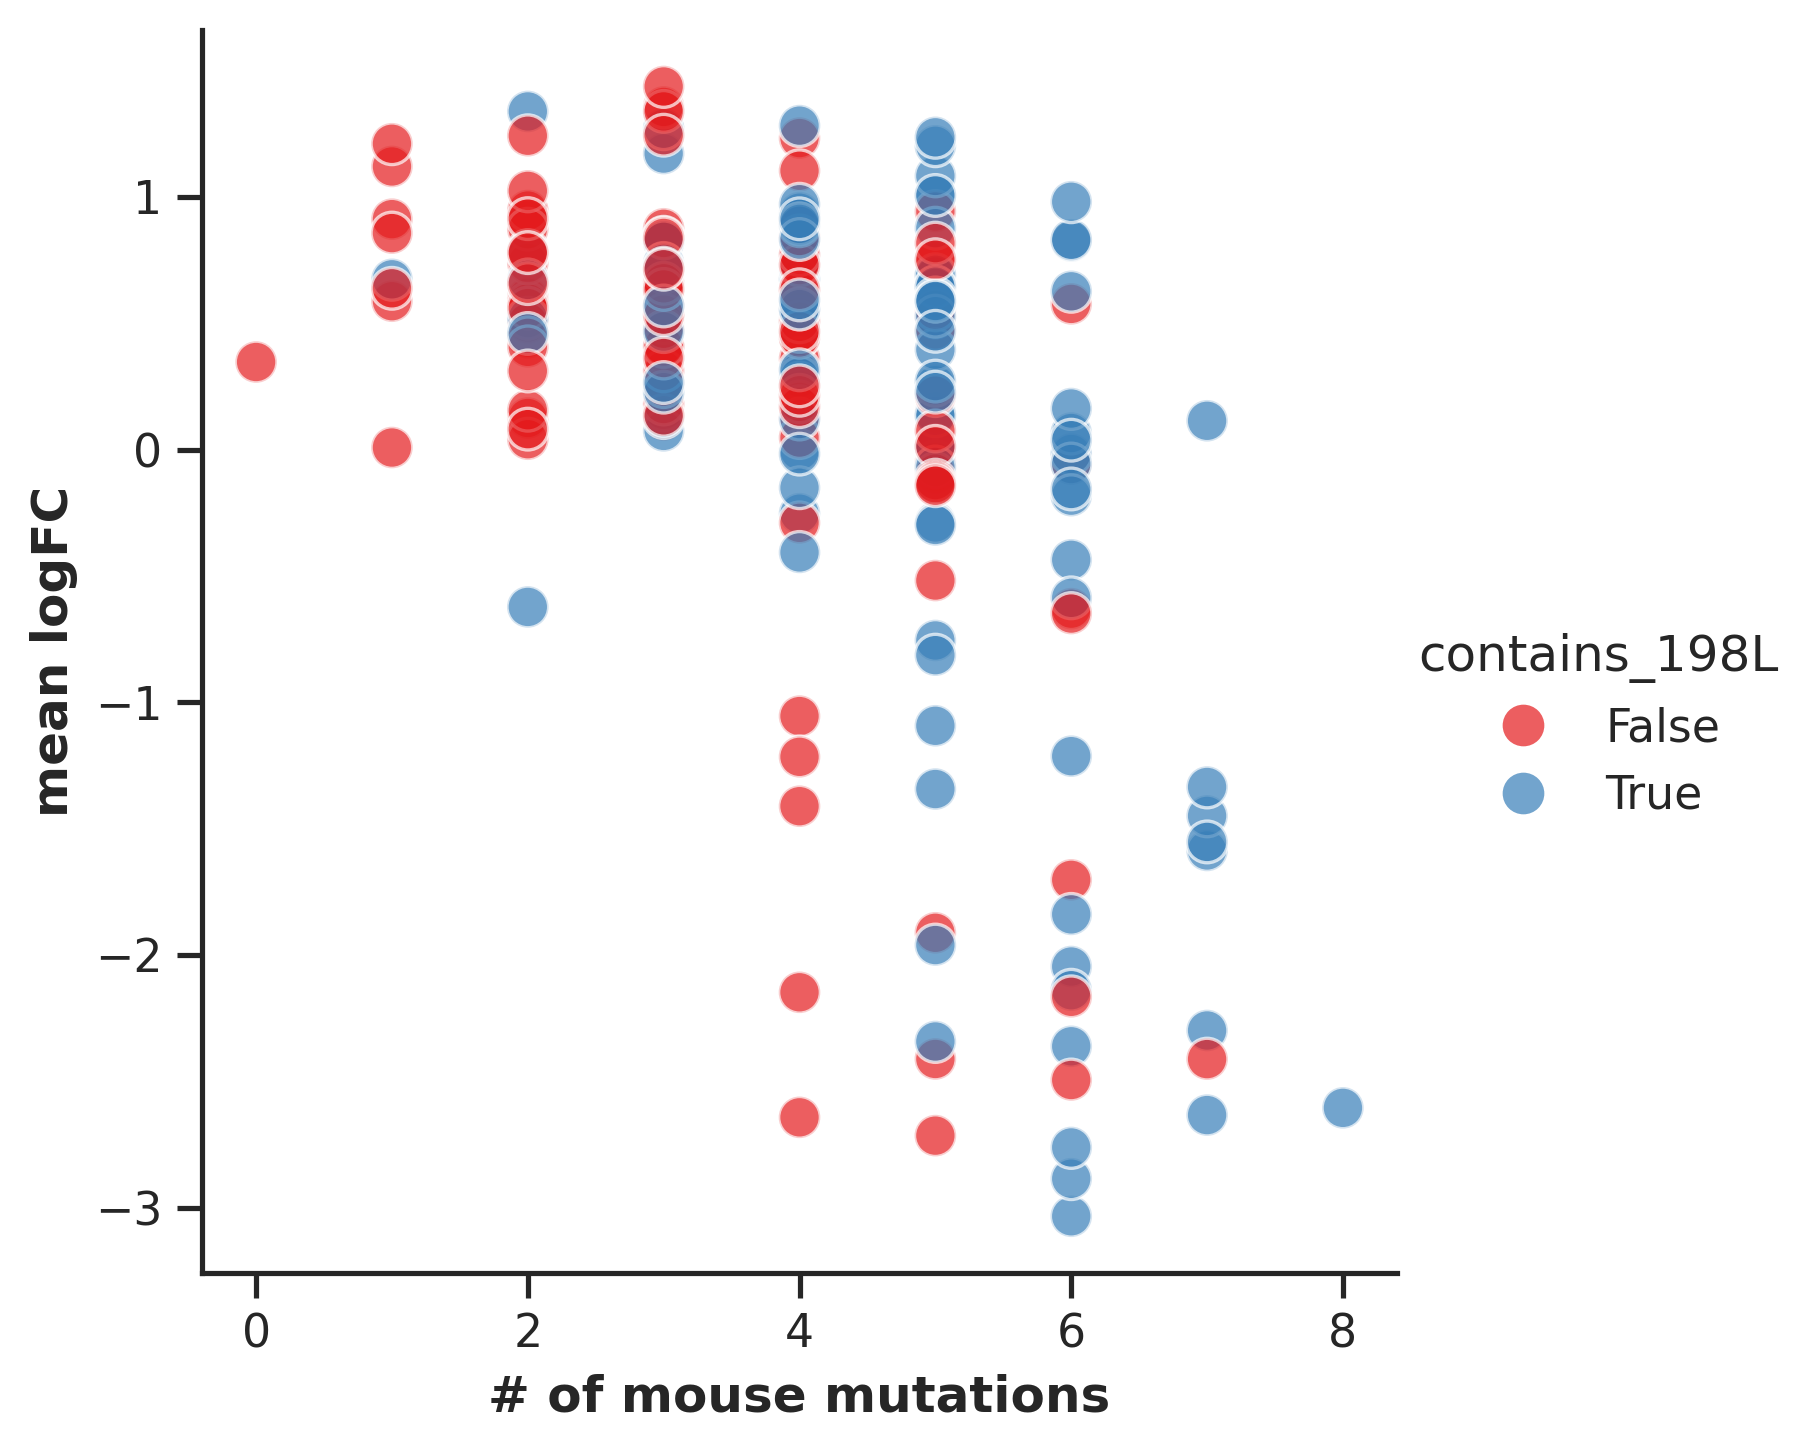

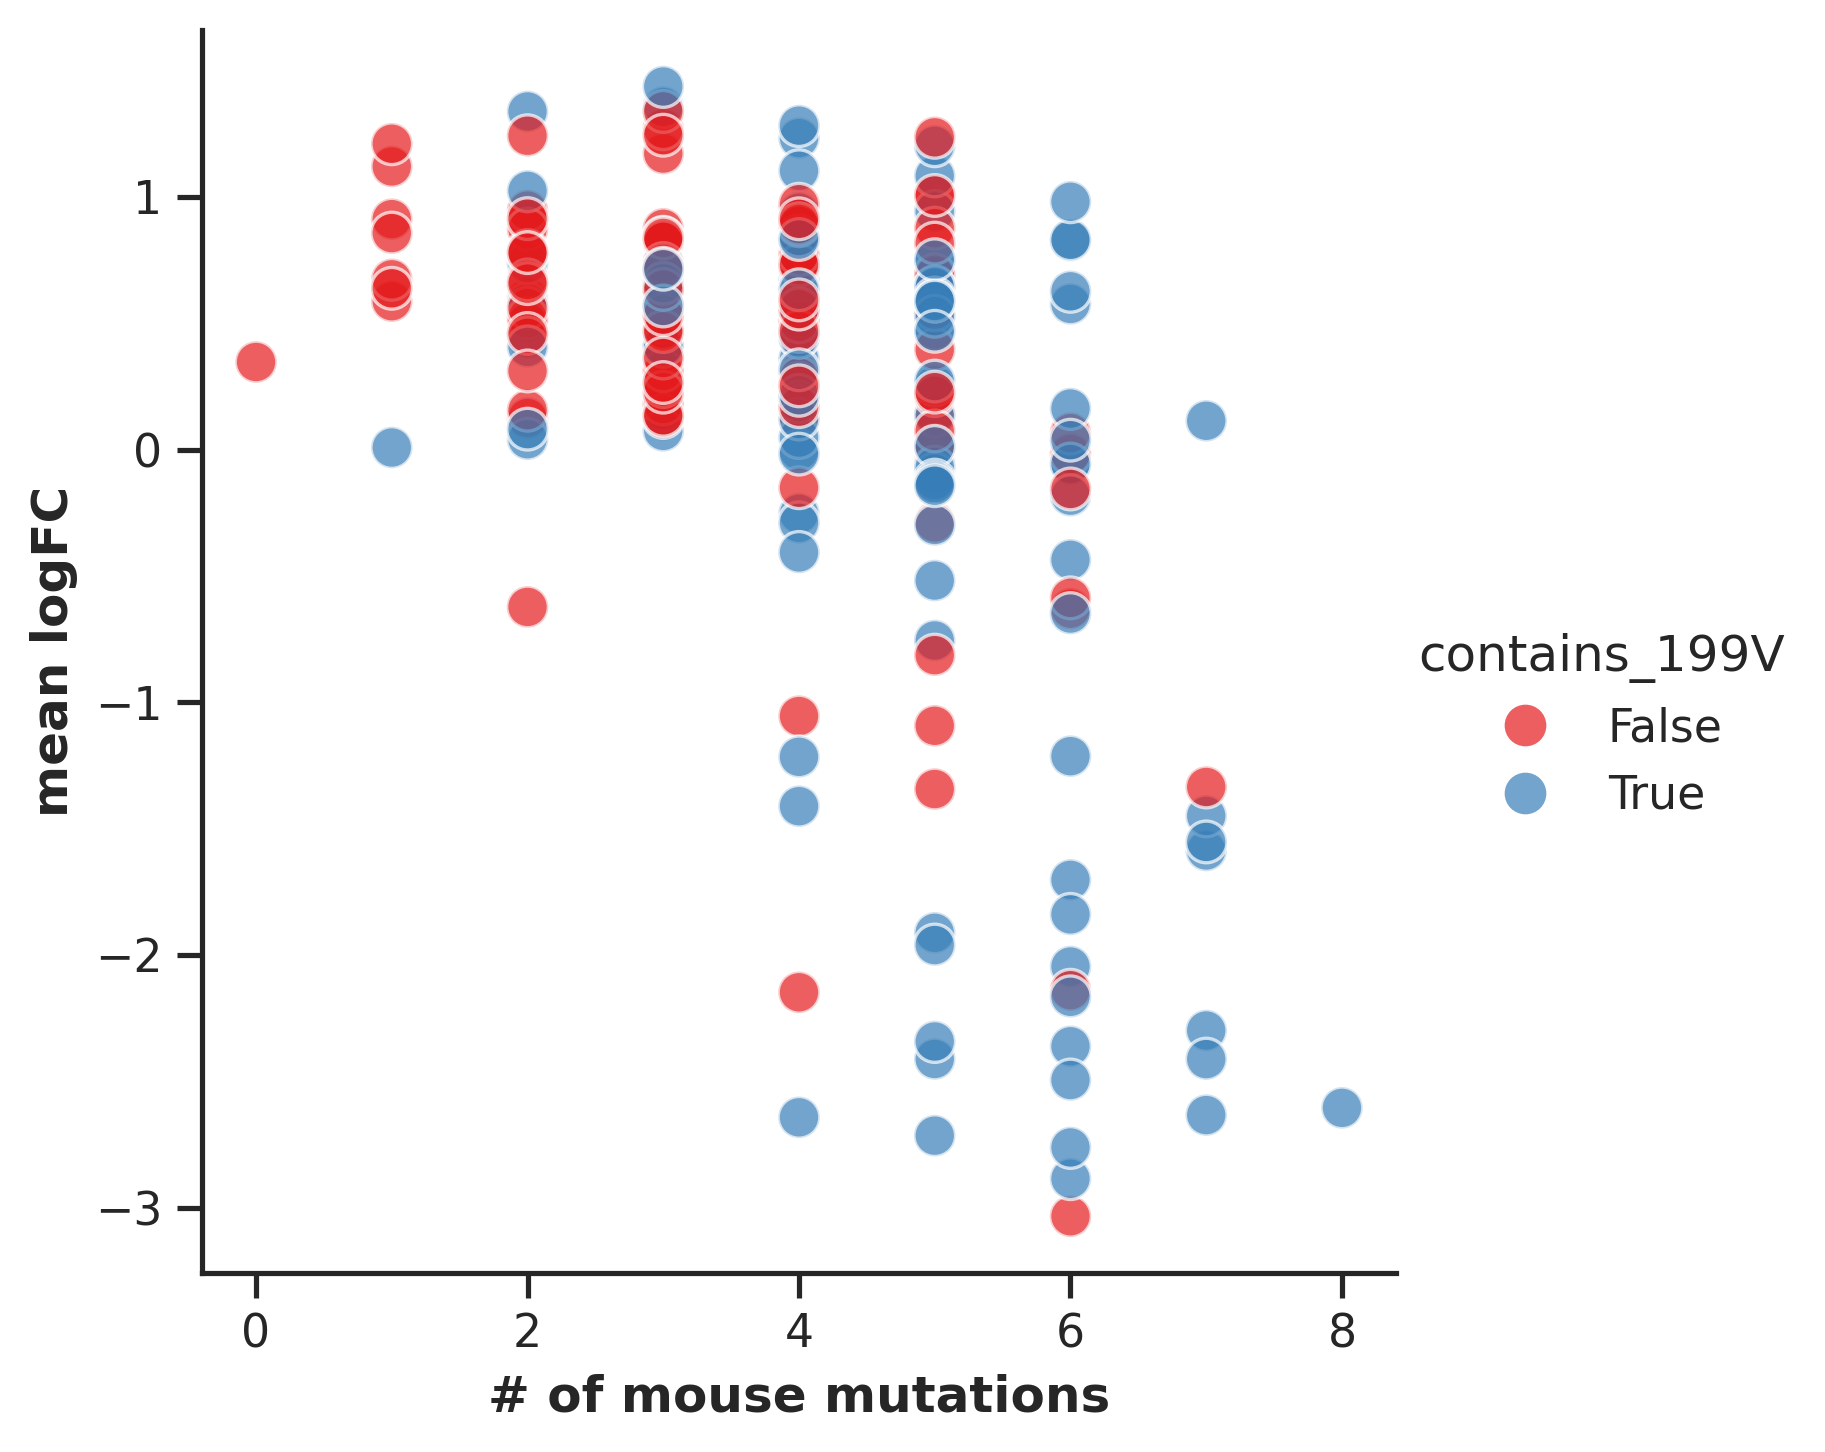

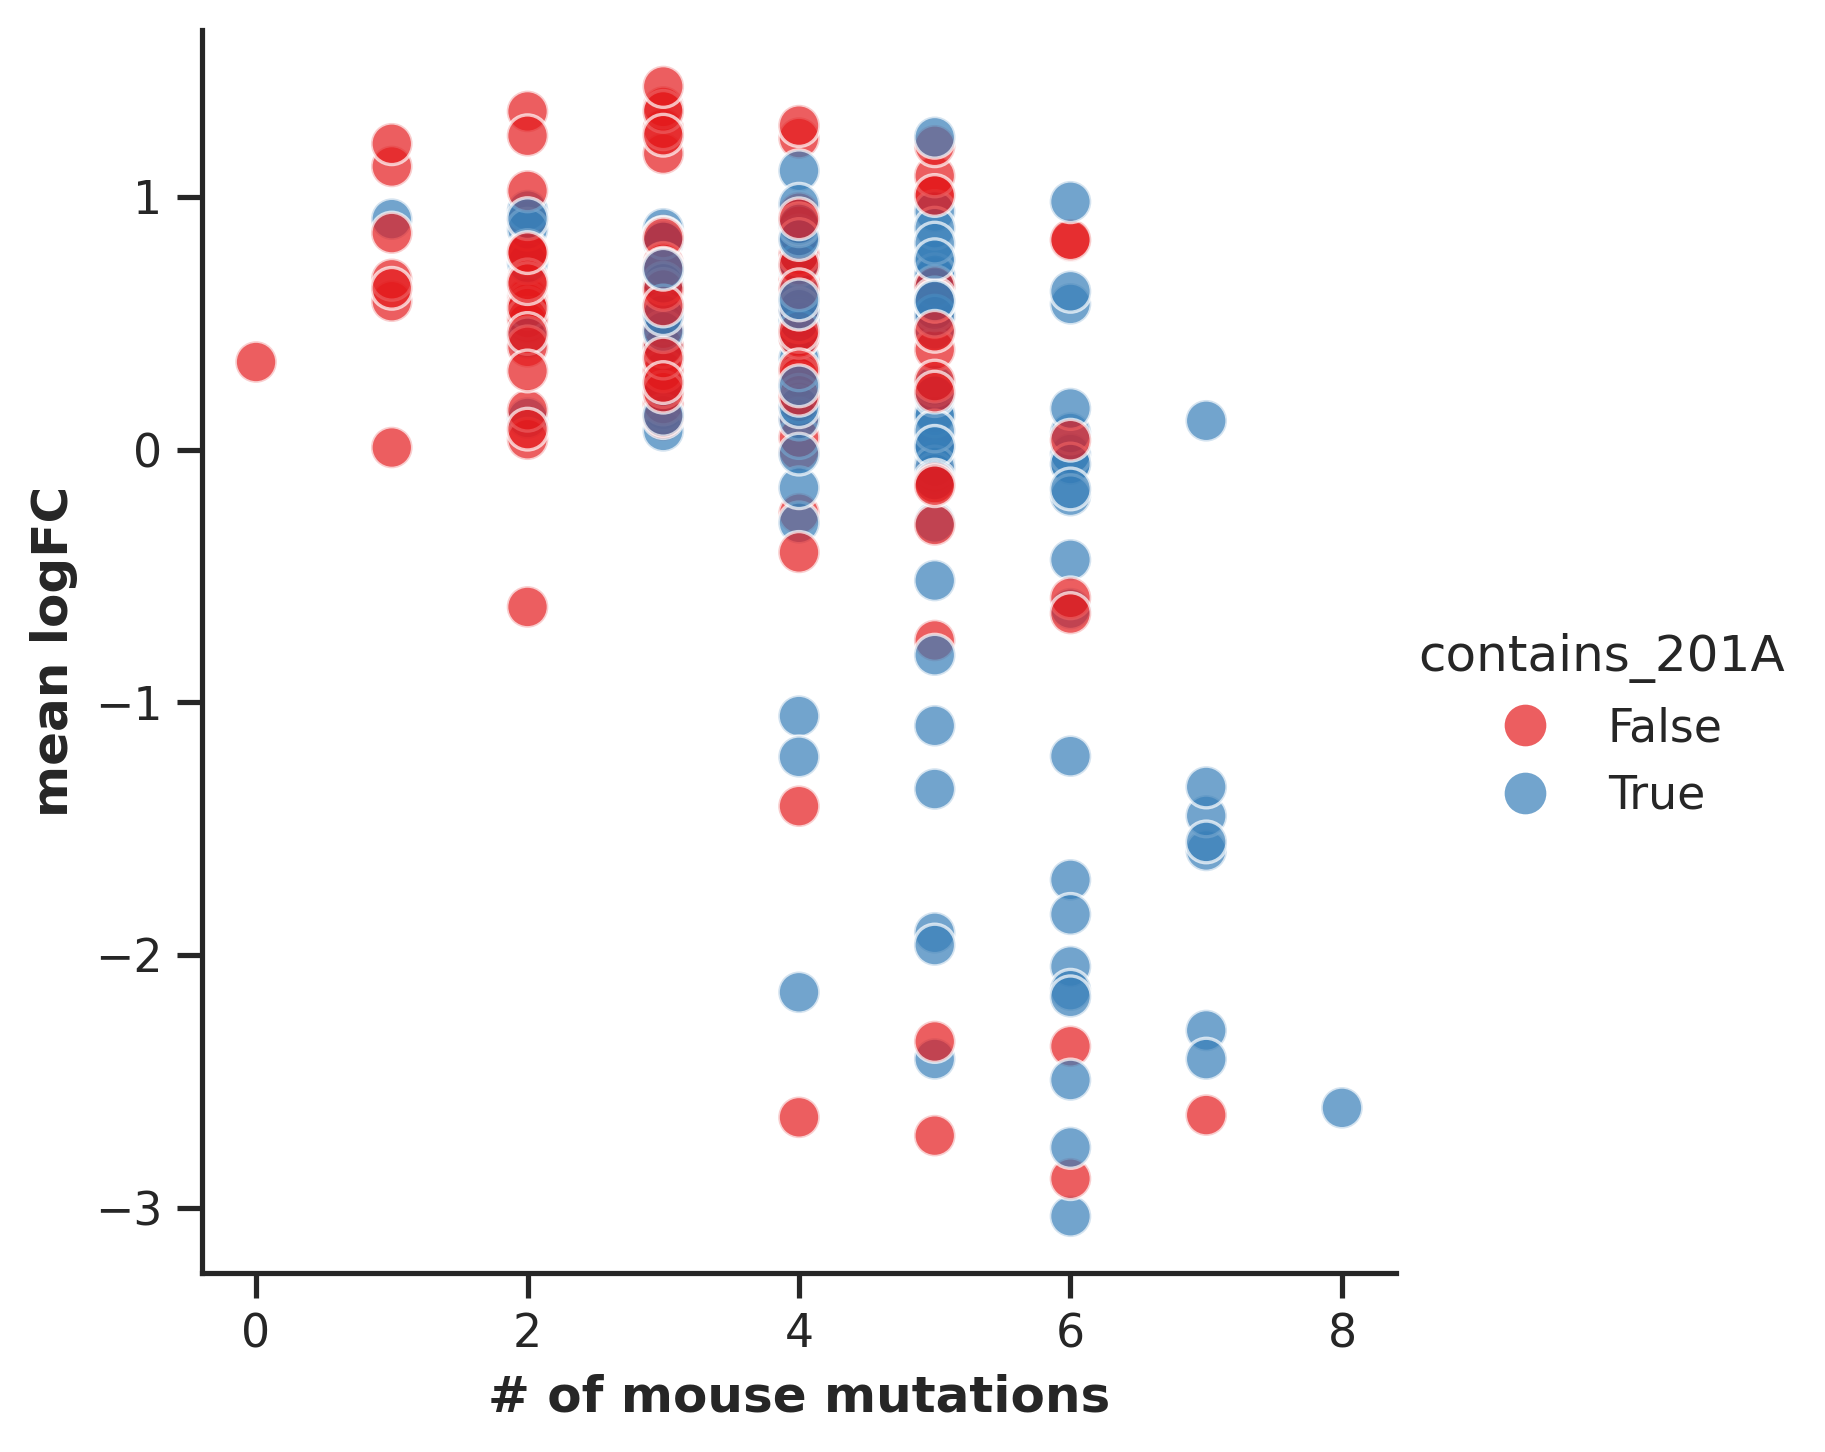

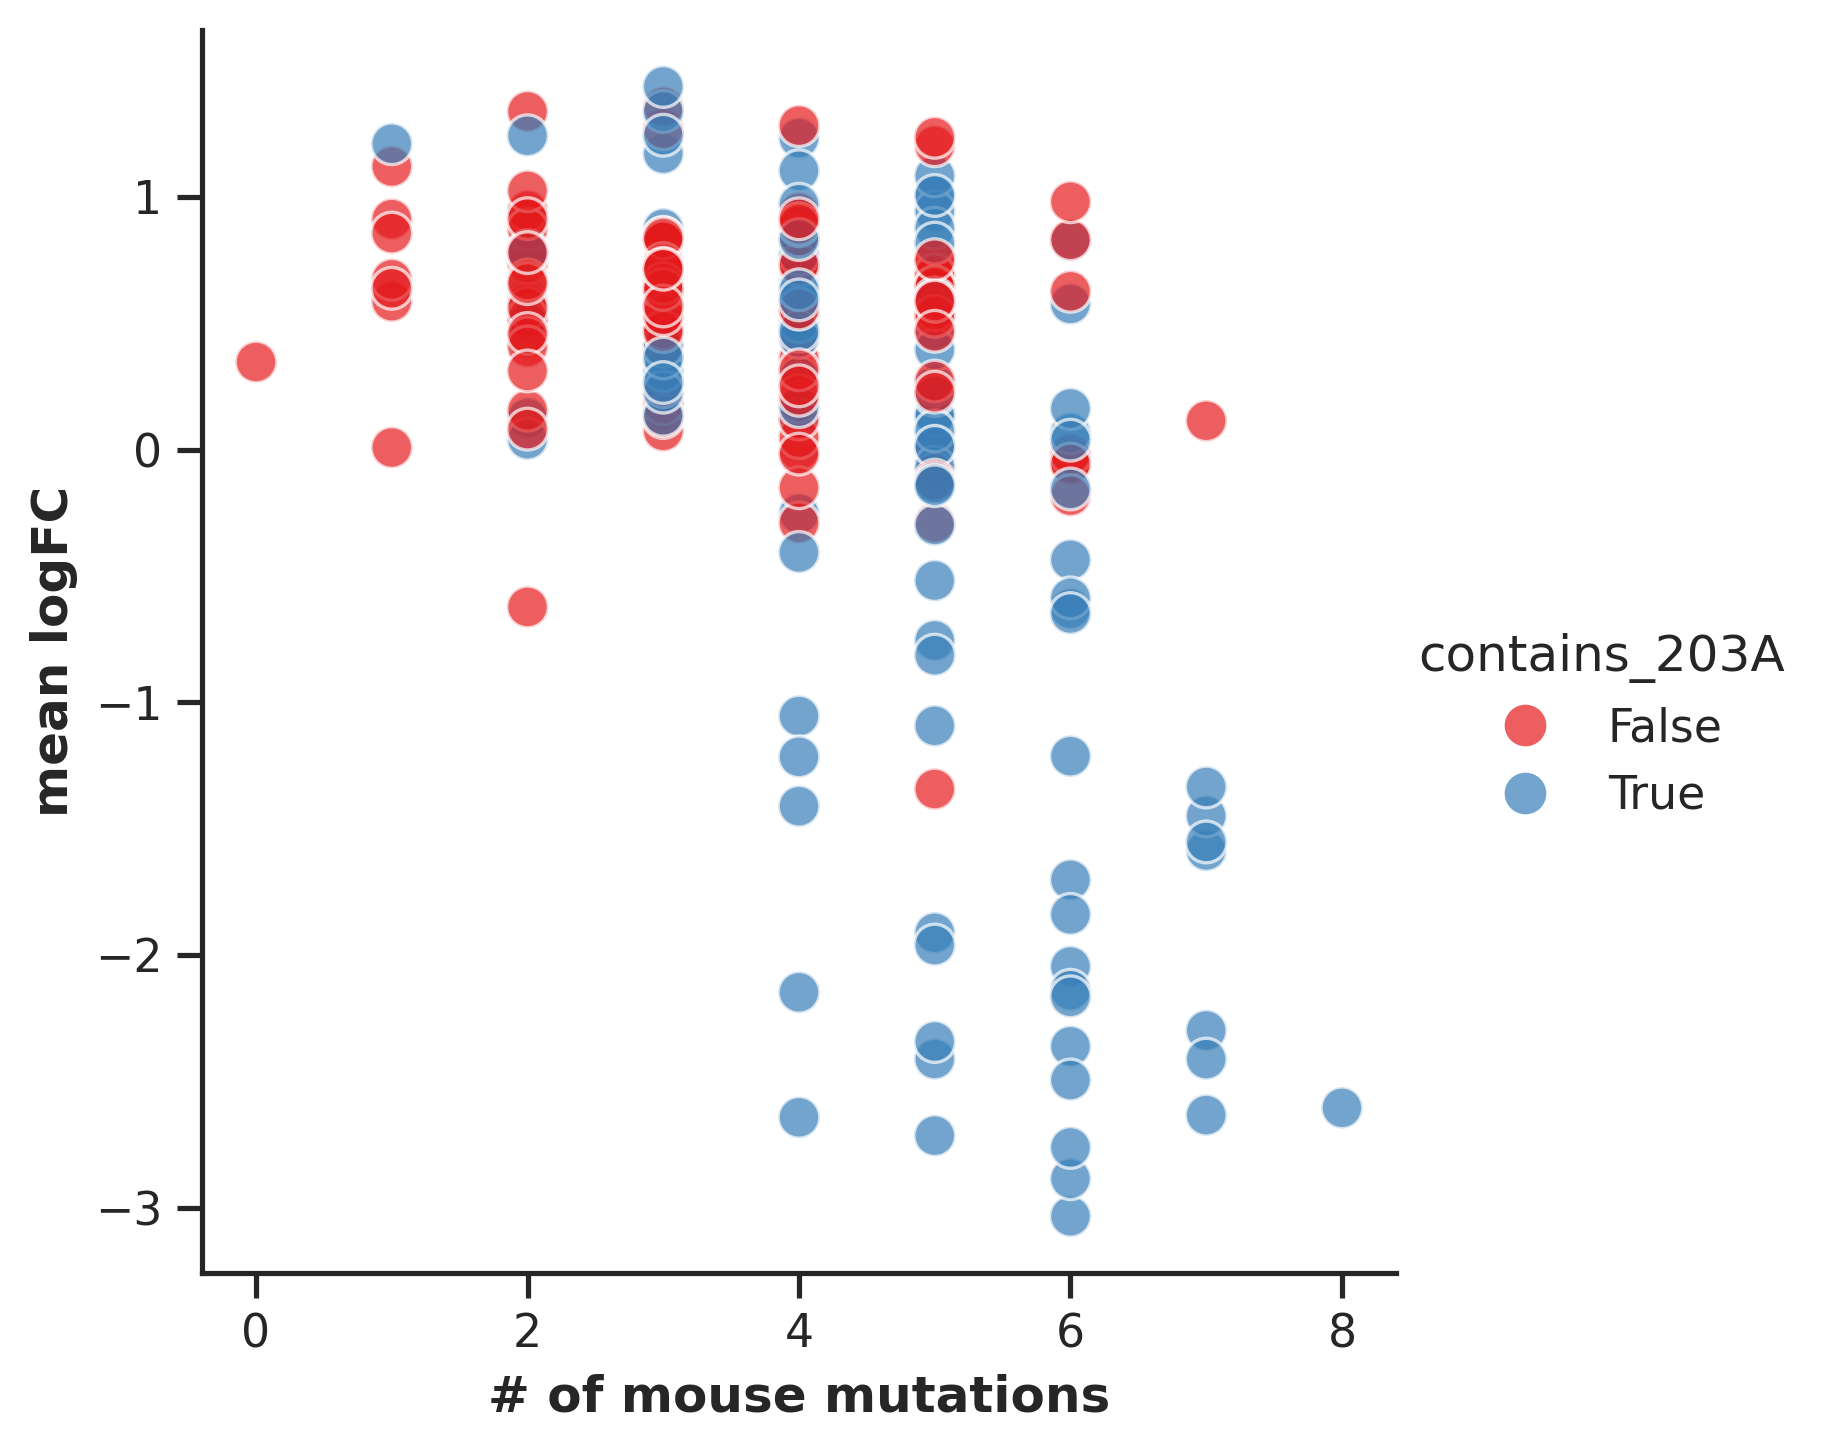

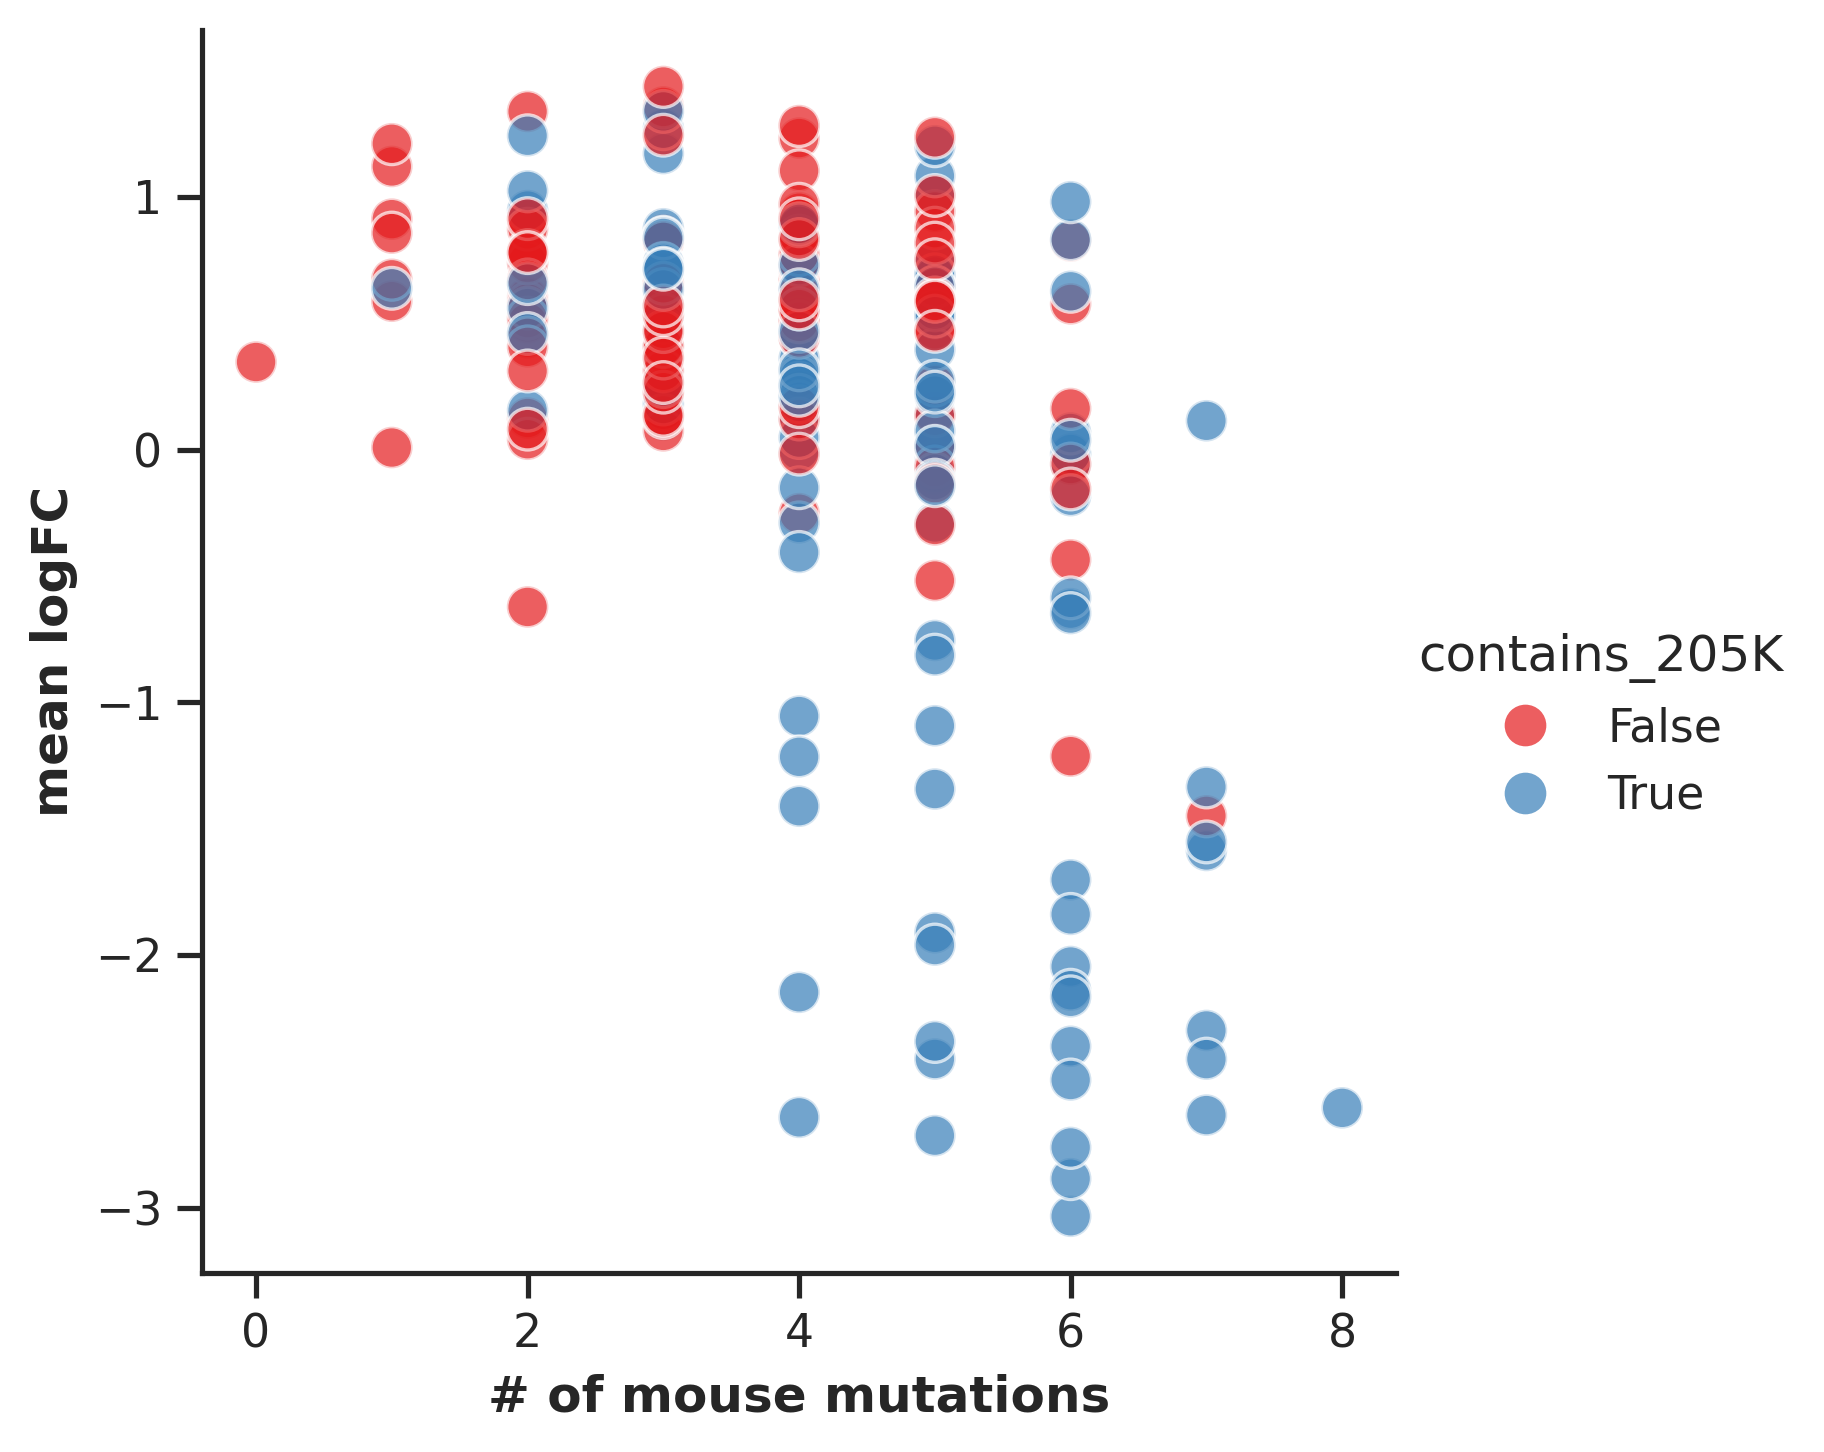

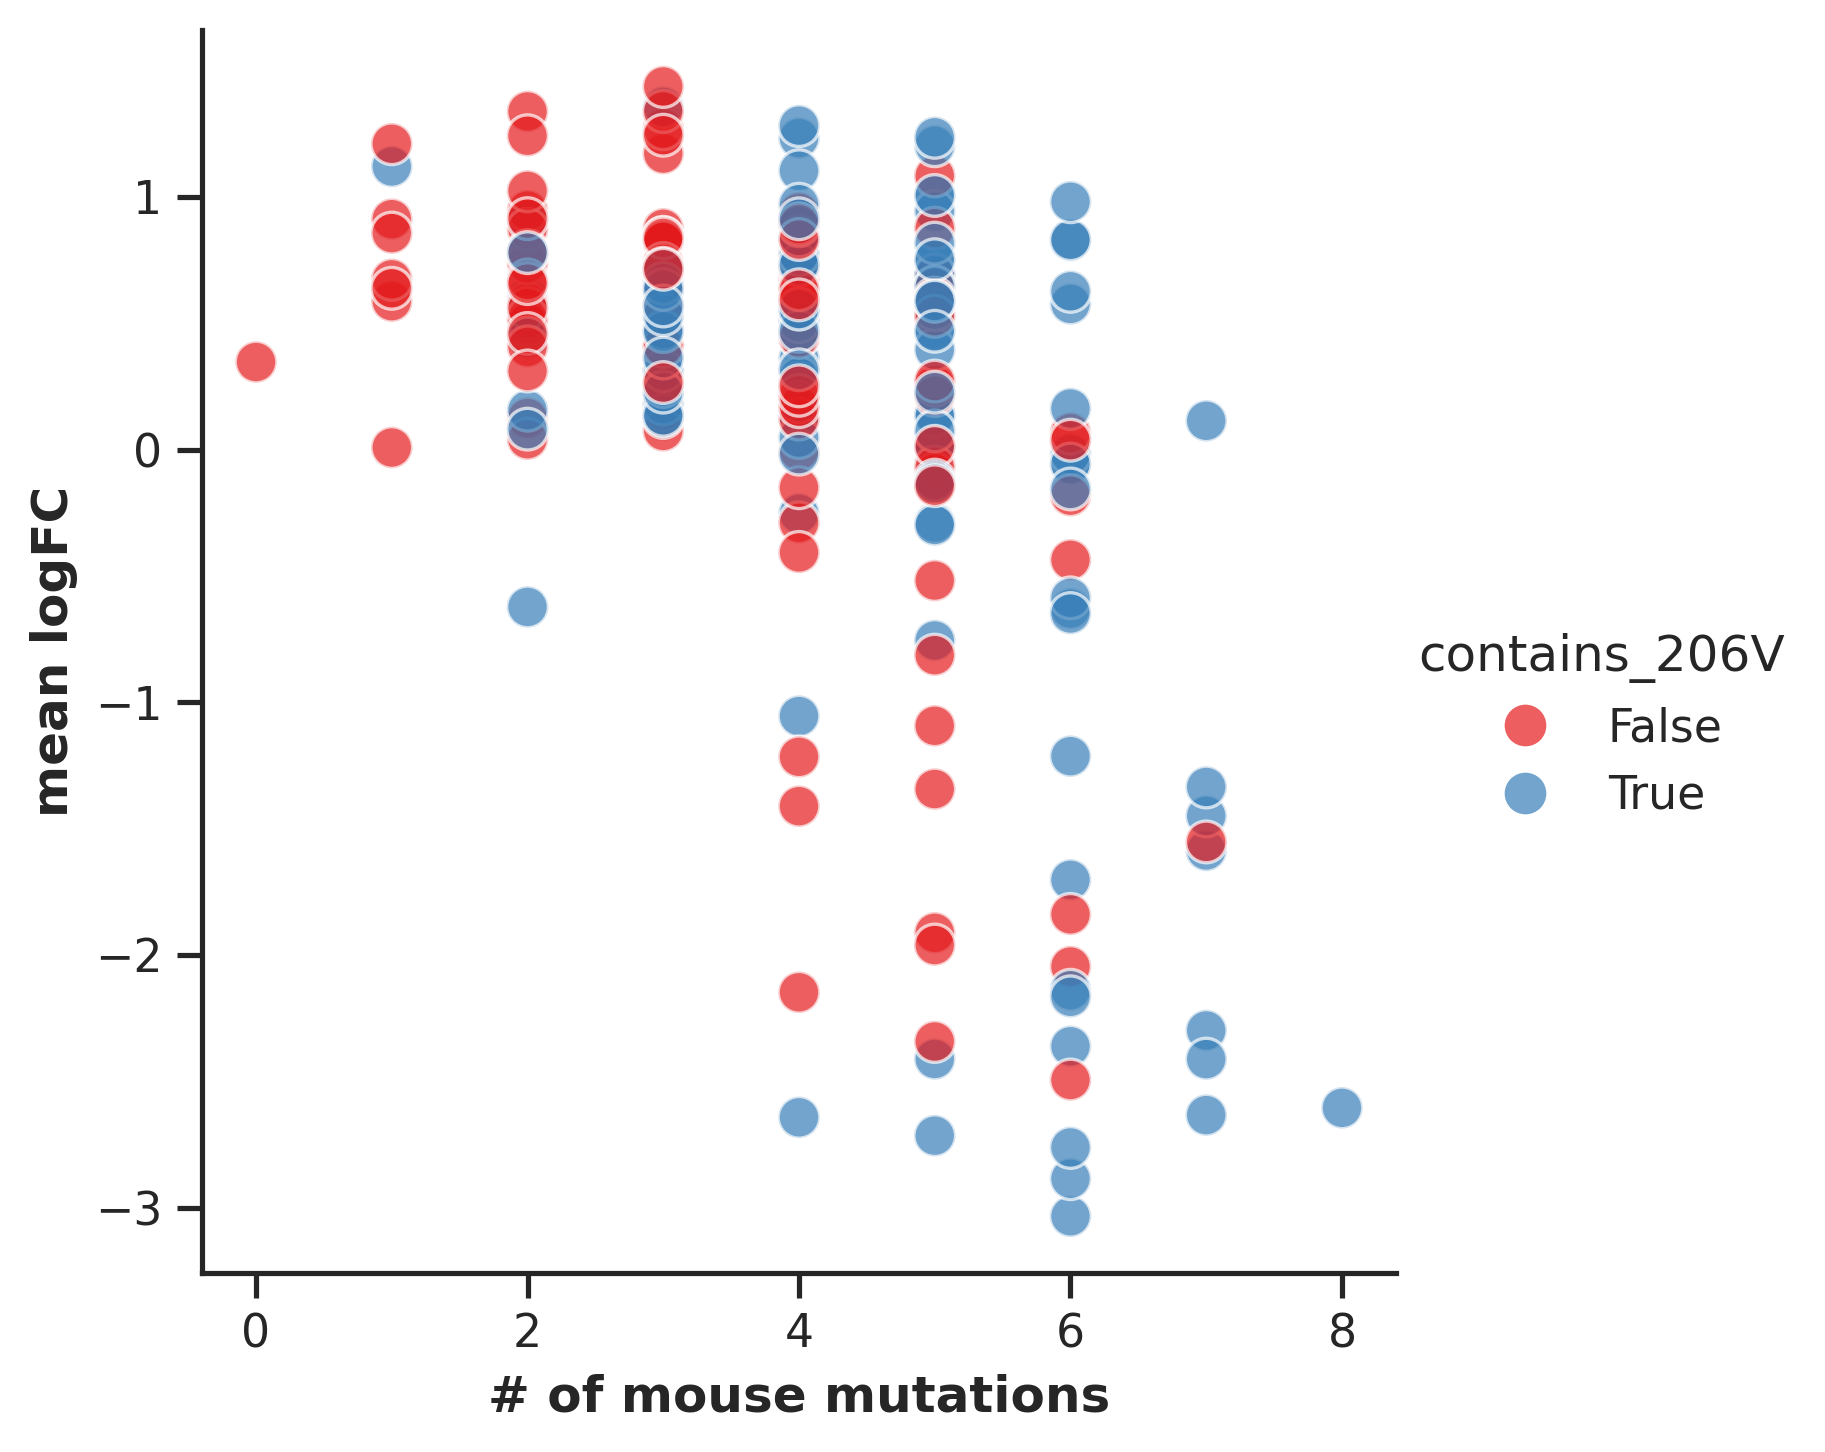

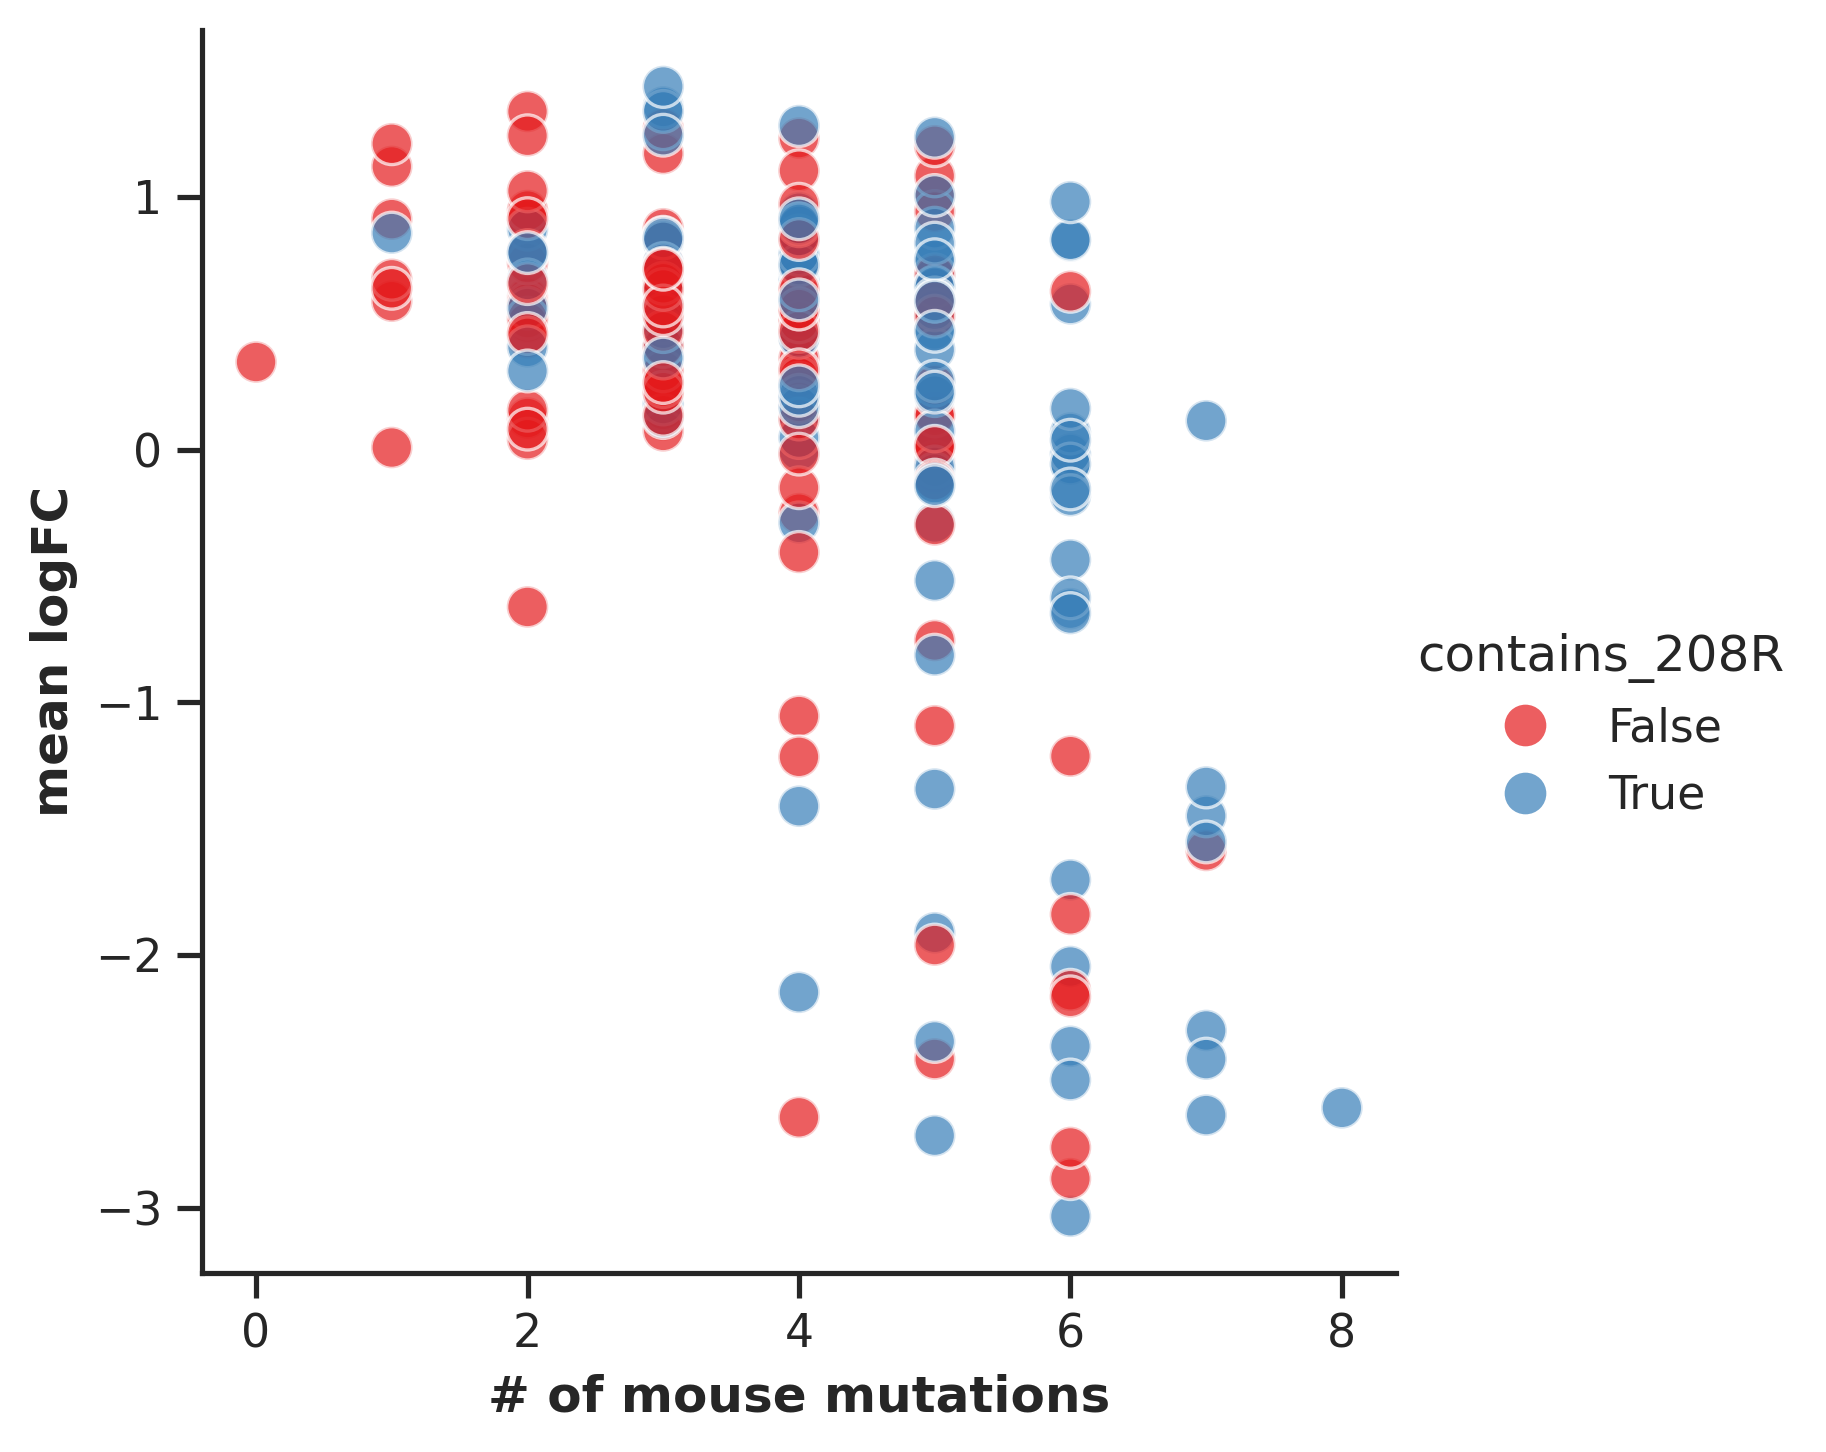

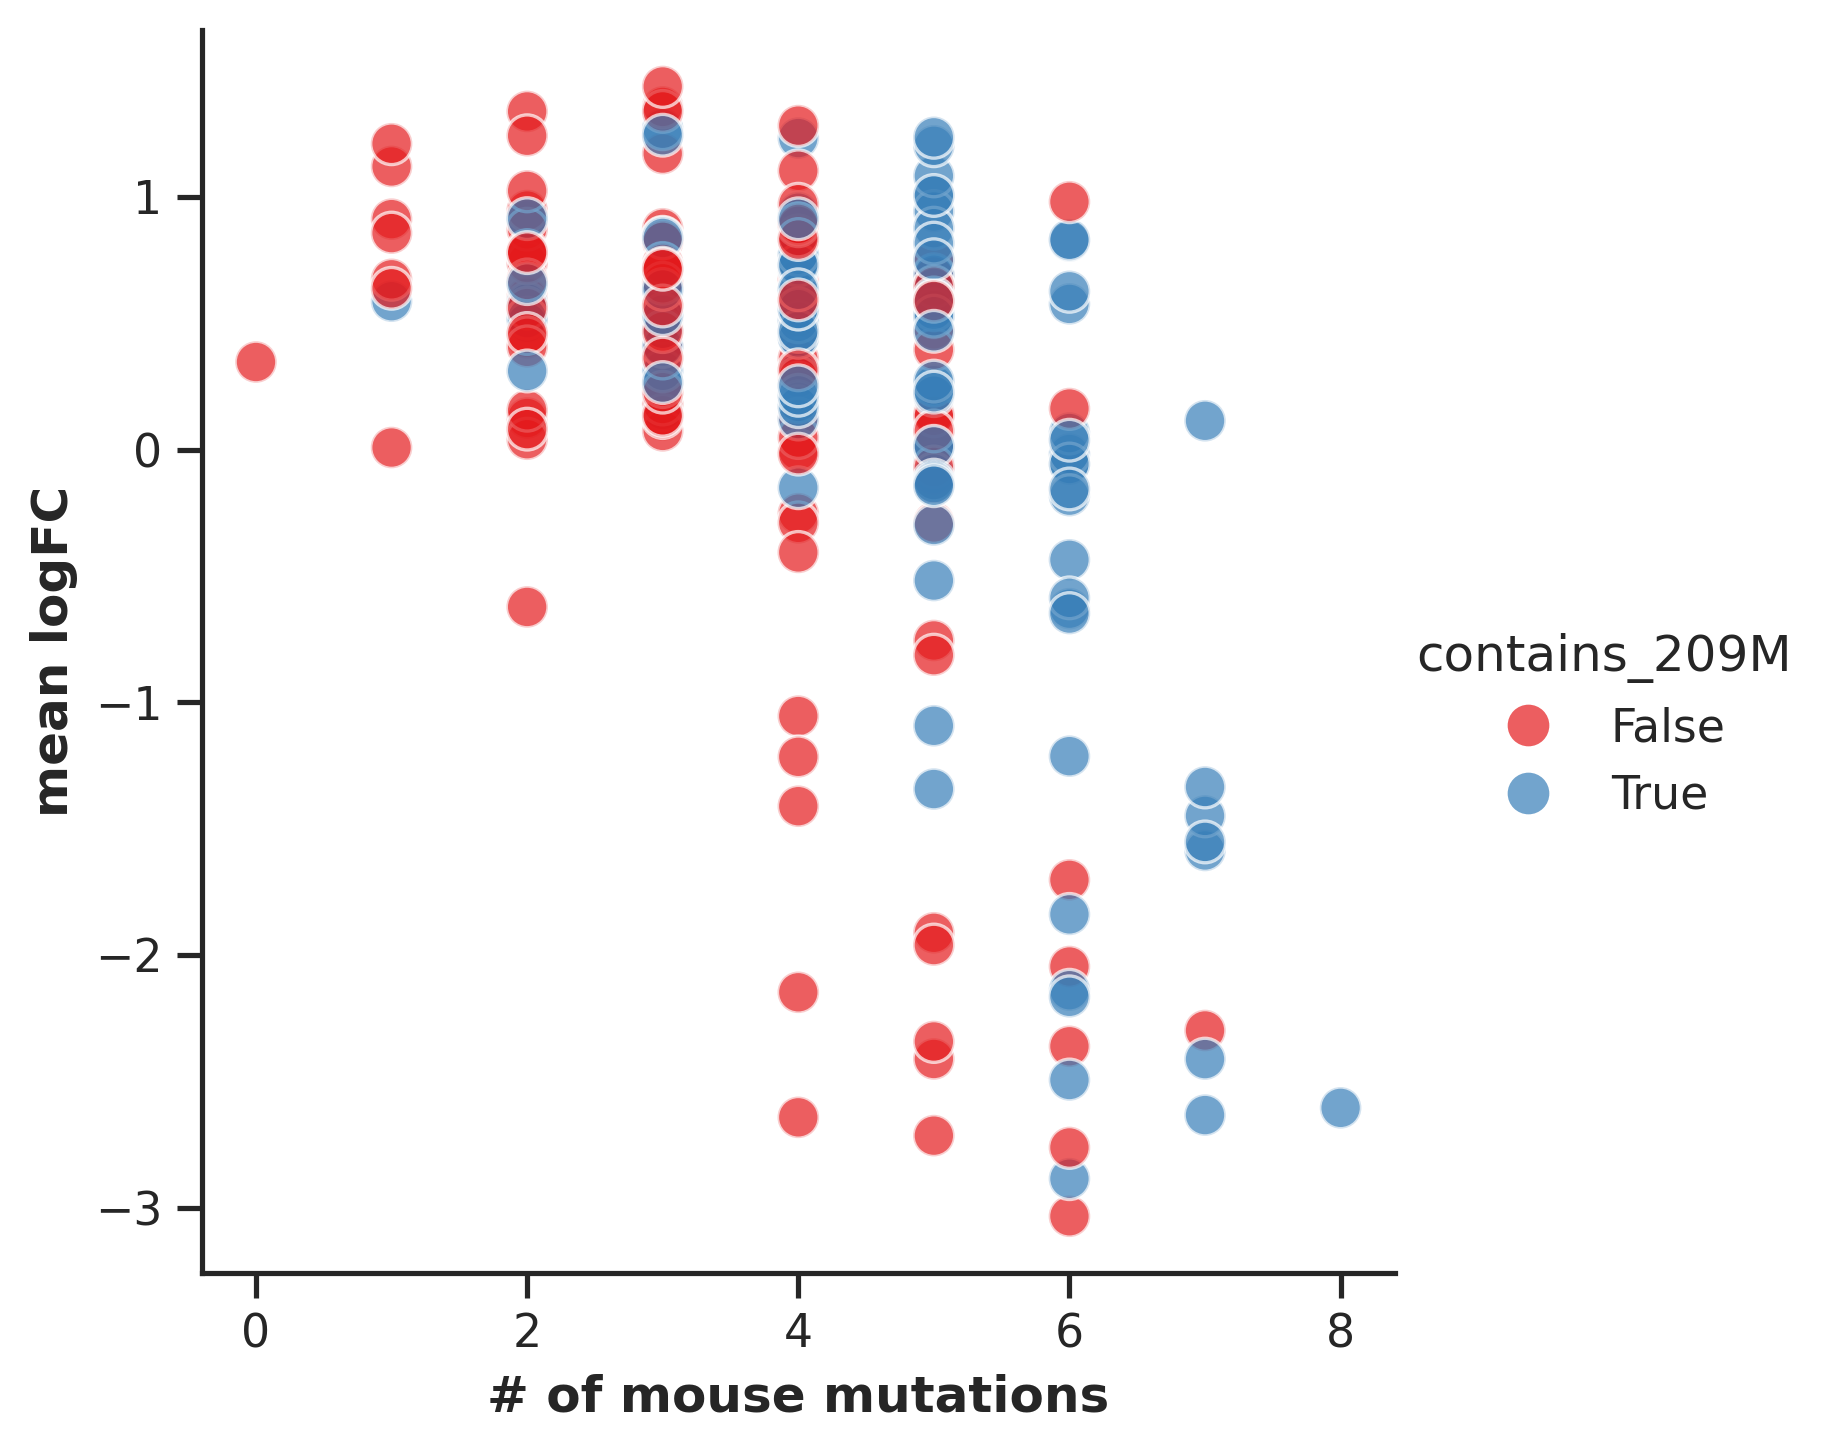

In [14]:
n = len(mouse_muts)

for i in range(n):

    mut = mouse_muts[i]
    
    count_muts_vs_fc = sns.relplot(data = merged_df,
                x = "count_mouse_muts", 
                y = "mean_logFC",
                hue = f'contains_{mut}',
                markers = ["o", "s"],
                aspect = 1,
                s = 100,
                alpha = 0.7,
                kind = "scatter",)
    
    count_muts_vs_fc.axes[0,0].set_xlabel(
        "# of mouse mutations", weight="bold")
    count_muts_vs_fc.axes[0,0].set_ylabel(
        "mean logFC", weight="bold")

    # Save plot
    outfile = os.path.join(plotsdir, f'count_mouse_muts_vs_logFC_{mut}.png')
    plt.savefig(outfile, dpi = 'figure')

In [15]:
# make interactive chart for exploring effects of mouse mutations
options = ['contains_198L', 'contains_199V', 'contains_201A', 'contains_203A',
           'contains_205K', 'contains_206V', 'contains_208R', 'contains_209M']

# make dropdown for which mouse mutations are indcluded
dropdown = alt.binding_select(
    options=options,
    name='mouse mutations '
)
color_param = alt.param(
    value='contains_198L',
    bind=dropdown
)

# make slider for standard deviation
slider = alt.binding_range(min=0, max=2.5, step=0.05, name = 'standard deviation cutoff')
cutoff = alt.param(bind=slider, value=2.5)

chart = alt.Chart(merged_df).mark_circle(size=120).encode(
    x='count_mouse_muts',
    y='mean_logFC',
    color=alt.Color('color:N').title(''),
    opacity=alt.condition(
        alt.datum.std < cutoff,
        alt.value(1), alt.value(0.1)
    ),
    tooltip=['prot_seq', 'mouse_muts', 'logFC_lib1','logFC_lib2', 'mean_logFC', 'std']
).interactive(
).transform_calculate(
    color=f'datum[{color_param.name}]'
).add_params(
    color_param,
    cutoff
)

chart.save('docs/scatterplot_highlight_mouseMuts.html')
chart

alt.Chart(...)

203A and 205K required for mouse behavior

203A/205K (each) must be paired with 3 other mutations to have effect

205K important for charge interaction with NS5. Must be 205E (human) to interact. Of the single mutations, it has the largest negative effect on binding. 

In [16]:
# make interactive chart for exploring effects of mouse mutations
mutations = ['contains_198L', 'contains_199V', 'contains_201A', 'contains_203A',
           'contains_205K', 'contains_206V', 'contains_208R', 'contains_209M']

dropdown_options = [True, False]

base = alt.Chart(merged_df).mark_circle(size=120).encode(
    x='count_mouse_muts',
    y='mean_logFC',
    # color=alt.Color('color:N').title(''),
    tooltip=['prot_seq', 'mouse_muts', 'mean_logFC',]
).interactive()

# A dropdown filter
option_dropdown = alt.binding_select(options=dropdown_options, name="198L")
mut_198_select = alt.selection_point(fields=['contains_198L'], bind=option_dropdown)

option_dropdown = alt.binding_select(options=dropdown_options, name="199V")
mut_199_select = alt.selection_point(fields=['contains_199V'], bind=option_dropdown)

option_dropdown = alt.binding_select(options=dropdown_options, name="201A")
mut_201_select = alt.selection_point(fields=['contains_201A'], bind=option_dropdown)

option_dropdown = alt.binding_select(options=dropdown_options, name="203A")
mut_203_select = alt.selection_point(fields=['contains_203A'], bind=option_dropdown)

option_dropdown = alt.binding_select(options=dropdown_options, name="205K")
mut_205_select = alt.selection_point(fields=['contains_205K'], bind=option_dropdown)

option_dropdown = alt.binding_select(options=dropdown_options, name="206V")
mut_206_select = alt.selection_point(fields=['contains_206V'], bind=option_dropdown)

option_dropdown = alt.binding_select(options=dropdown_options, name="208R")
mut_208_select = alt.selection_point(fields=['contains_208R'], bind=option_dropdown)

option_dropdown = alt.binding_select(options=dropdown_options, name="209M")
mut_209_select = alt.selection_point(fields=['contains_209M'], bind=option_dropdown)


chart = (base.add_params(mut_198_select).transform_filter(mut_198_select).properties(title="Dropdown Filtering")
         .add_params(mut_199_select).transform_filter(mut_199_select).properties(title="Dropdown Filtering")
         .add_params(mut_201_select).transform_filter(mut_201_select).properties(title="Dropdown Filtering")
         .add_params(mut_203_select).transform_filter(mut_203_select).properties(title="Dropdown Filtering")
         .add_params(mut_205_select).transform_filter(mut_205_select).properties(title="Dropdown Filtering")
         .add_params(mut_206_select).transform_filter(mut_206_select).properties(title="Dropdown Filtering")
         .add_params(mut_208_select).transform_filter(mut_208_select).properties(title="Dropdown Filtering")
         .add_params(mut_209_select).transform_filter(mut_209_select).properties(title="Dropdown Filtering")
        )

chart


# # A dropdown filter
# genre_dropdown = alt.binding_select(options=genres, name="Genre")
# genre_select = alt.selection_point(fields=['Major_Genre'], bind=genre_dropdown)

# filter_genres = base.add_params(
#     genre_select
# ).transform_filter(
#     genre_select
# ).properties(title="Dropdown Filtering")


alt.Chart(...)

For whatever reason, this isn't quite working still. At first it behaves as expected-- switching mutations to `False` removes their sequences from graph (except at `count_mouse_muts = 0`). But then, adding back mutations (switching back from `False` to `True`) only adds those sequences that contain exactly those mutations that say `True`. Not sure why this is happening. Not sure if it's worth spending more time on.

/tmp/ipykernel_57817/2157669824.py:39: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  chart = sns.catplot(
/home/ckikawa/.conda/envs/EvansLab_combinatorial_NS5/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


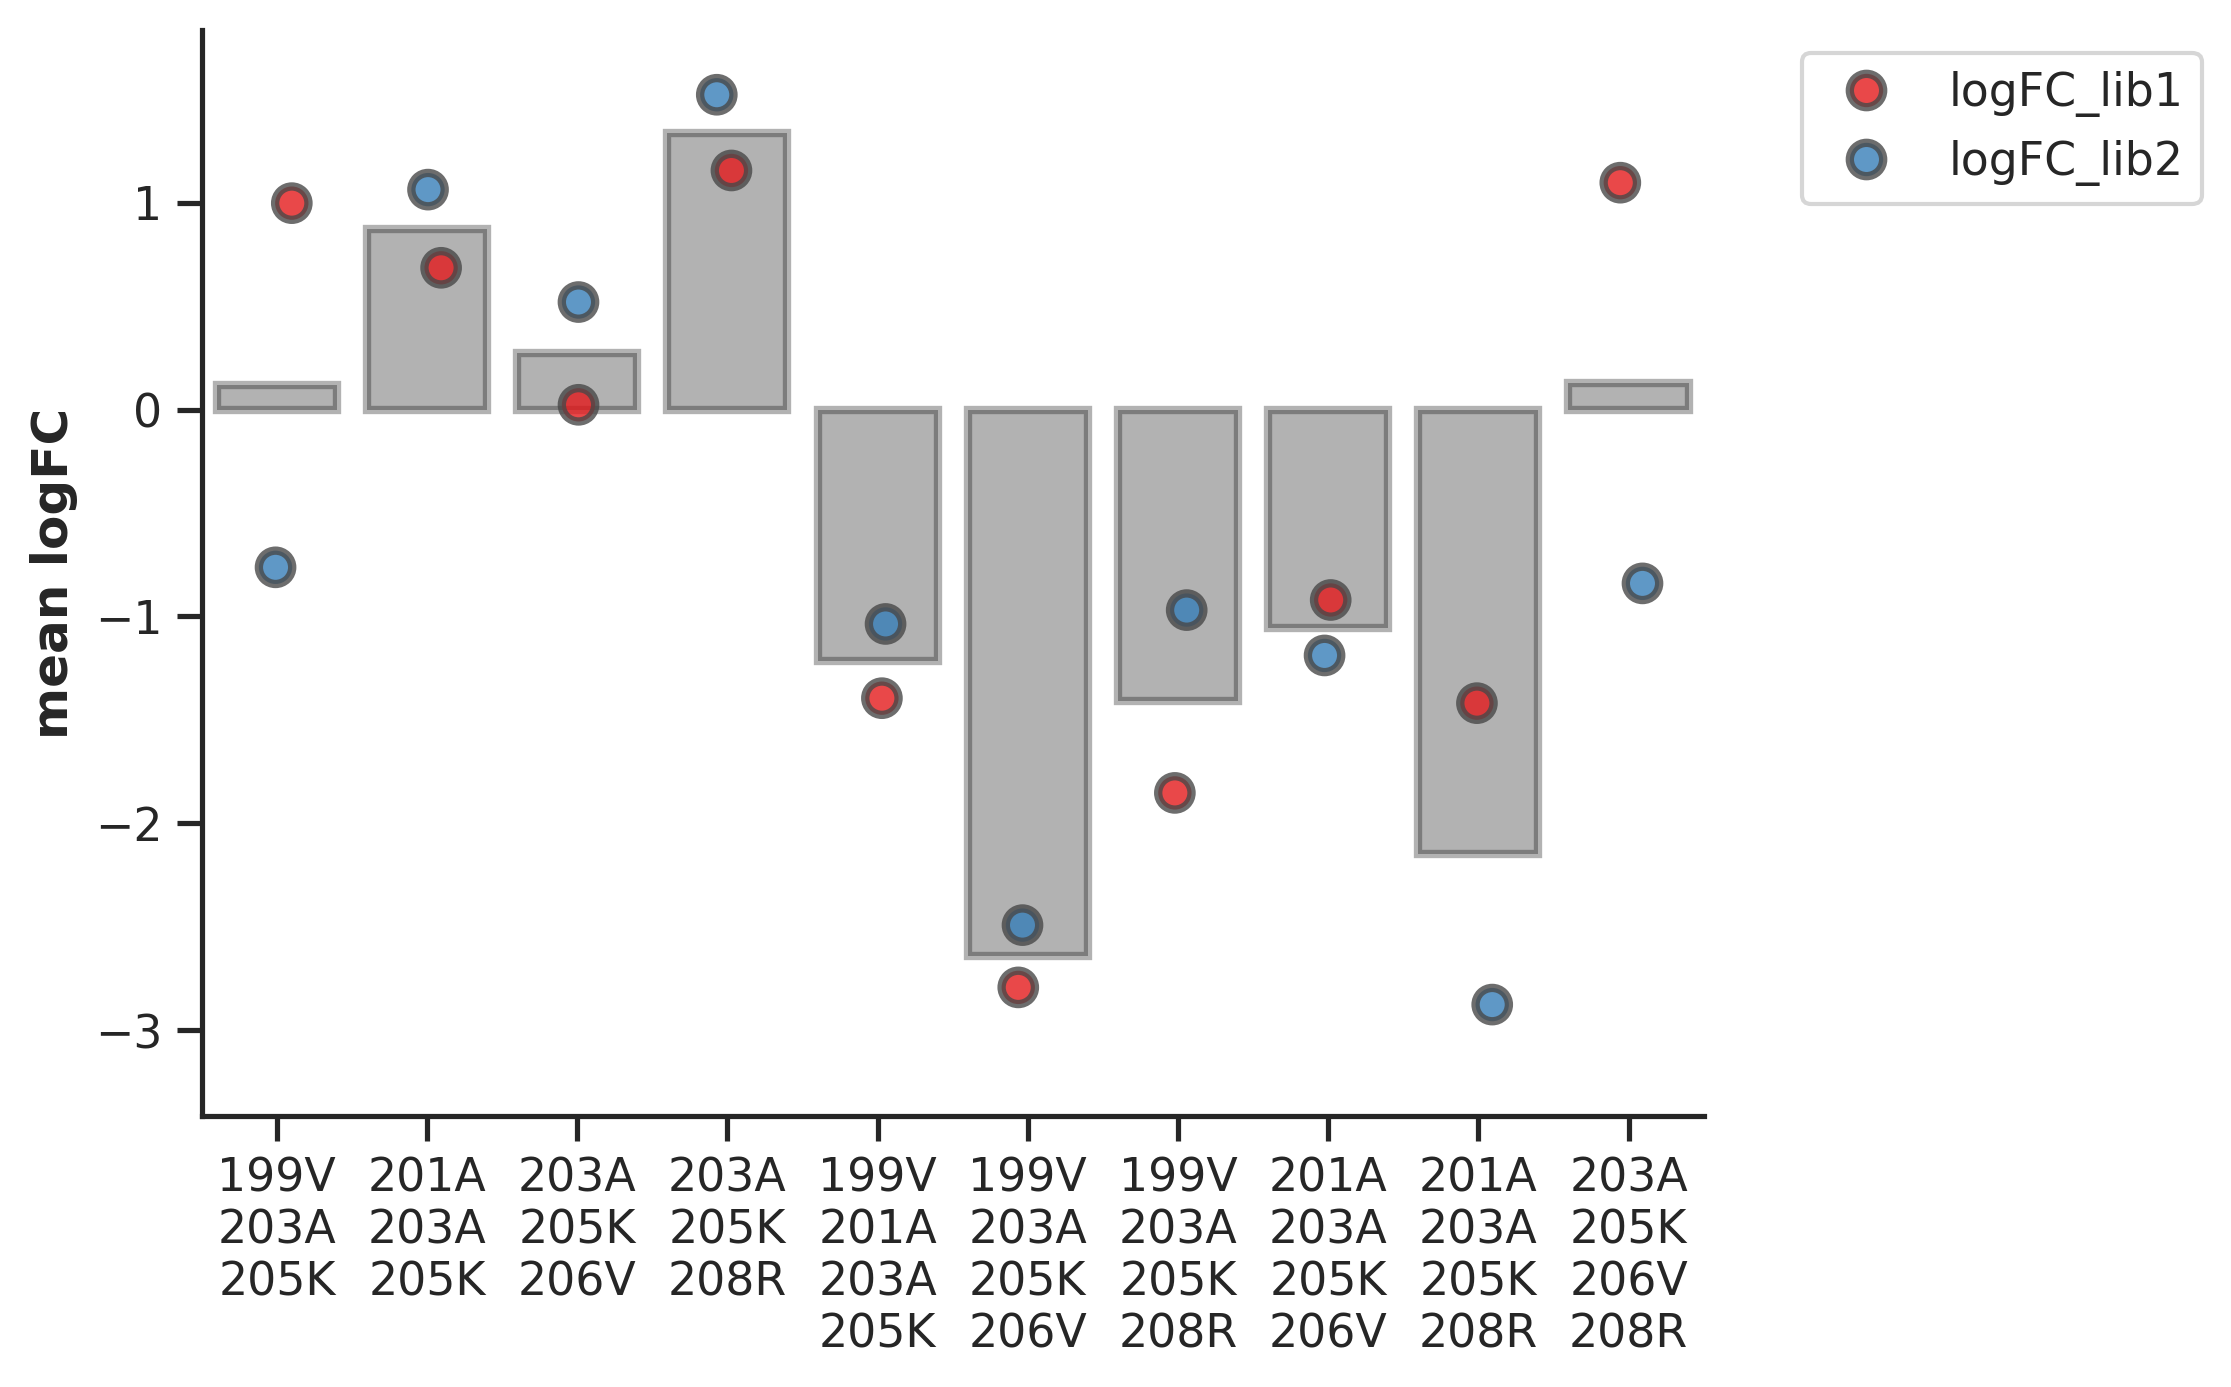

In [17]:
merged_203_205_df = (merged_df
                     .query('contains_203A == True')
                     .query('contains_205K == True')
                    )


# want to show for additional single muts: 199, 201, 206, 208
# and then all double combinations 
paired_muts = ['199V', '201A' , '206V', '208R']

df = pd.DataFrame()

for n in paired_muts:
    single_mut = (merged_203_205_df
                  .query(f'contains_{n} == True')
                  .query('count_mouse_muts == 3'))

    df = pd.concat([df, single_mut])
    
    for n_double in paired_muts:
        if n == n_double:
            pass
        else:
            double_mut = (merged_203_205_df
                          .query(f'contains_{n} == True')
                          .query(f'contains_{n_double} == True')
                          .query('count_mouse_muts == 4'))
            df = pd.concat([df, double_mut])
            # .sort_values(by=['count_mouse_muts'], ascending=True)

df['mouse_muts_str'] = ['\n'.join(map(str, l)) for l in df['mouse_muts']]
df = df.sort_values(by=['count_mouse_muts', 'contains_199V'], ascending = [True, False])

dfm = (df[['mouse_muts_str', 'logFC_lib1', 'logFC_lib2']]
       .melt('mouse_muts_str', var_name='lib', value_name='vals')
       .drop_duplicates()
      )

chart = sns.catplot(
            x = 'mouse_muts_str', 
            y = 'vals',
    # palette = sns.color_palette("rocket"),
    color = 'black',
    data=dfm, 
    kind="bar", 
    errorbar = "sd", 
    edgecolor="black",
    linewidth = 2,
    errwidth=0,
    aspect = 1.2,
    alpha=0.3)

# map data to stripplot
chart.map(sns.stripplot, 
          'mouse_muts_str', 
          'vals', 
          'lib', 
          hue_order=['logFC_lib1', 'logFC_lib2'], 
          palette = sns.color_palette("Set1")[:2],
          alpha=0.8, 
          s = 8,
          linewidth = 2,
         )

chart.axes[0,0].set_xlabel(
    '', weight='bold')
chart.axes[0,0].set_ylabel(
    'mean logFC', weight='bold')

# add legend
plt.legend(bbox_to_anchor=(1.05, 1))

# Save plot
outfile = os.path.join(plotsdir, 'mut_combinations_with_203_205.png')
plt.savefig(outfile, dpi = 'figure', bbox_inches = 'tight')

In [18]:
chart = alt.Chart(merged_df.query('count_mouse_muts == 2')).mark_circle(size=120).encode(
    x='mouse_muts',
    y='mean_logFC',
    color='contains_203A',
    tooltip=['prot_seq', 'mouse_muts', 'mean_logFC']
).interactive()

chart

alt.Chart(...)

In [19]:
merged_df.query('count_mouse_muts == 4').sort_values(by = 'mean_logFC', ascending = True).head(5)[['mean_logFC', 'mouse_muts']]

,mean_logFC,mouse_muts
17,-2.642600,"[199V, 203A, 205K, 206V]"
64,-2.147732,"[201A, 203A, 205K, 208R]"
82,-1.411255,"[199V, 203A, 205K, 208R]"
165,-1.215841,"[199V, 201A, 203A, 205K]"
83,-1.054641,"[201A, 203A, 205K, 206V]"


Need a size reduction in binding epitope and charge swap (205K)

In [20]:
merged_df.query('count_mouse_muts == 5').sort_values(by = 'mean_logFC', ascending = True).head(7)[['mean_logFC', 'mouse_muts']]

,mean_logFC,mouse_muts
10,-2.715002,"[199V, 203A, 205K, 206V, 208R]"
66,-2.411620,"[199V, 201A, 203A, 205K, 206V]"
91,-2.342486,"[198L, 199V, 203A, 205K, 208R]"
12,-1.960800,"[198L, 199V, 201A, 203A, 205K]"
6,-1.912248,"[199V, 201A, 203A, 205K, 208R]"
4,-1.343323,"[198L, 201A, 205K, 208R, 209M]"
59,-1.092988,"[198L, 201A, 203A, 205K, 209M]"


It might be interesting to focus on the count = 4 (or count = 5) group initially, since this is a binary population of non-interactors and interactors

In [21]:
# there are 70 unique entries in the counts=4 group
# there are 56 unique entries in the counts=5 group


# merged_df.query('count_mouse_muts == 4')

# print(len(merged_df.query('count_mouse_muts == 5')))


merged_203_205_df

,nc_seq,count_2x_lib1,count_4xplus_lib1,FC_lib1,logFC_lib1,count_2x_lib2,count_4xplus_lib2,FC_lib2,logFC_lib2,mean_FC,...,count_mouse_muts,contains_198L,contains_199V,contains_201A,contains_203A,contains_205K,contains_206V,contains_208R,contains_209M,std
0,ATCGTTCAGGCAACTGCTAATAAGGTAGACAGAAGG,1566,394,0.251596,-1.379929,3987,526,0.131929,-2.025493,0.191763,...,6,False,True,True,True,True,True,True,False,0.456483
1,CTACTACAGGAGACTGCTAATAAGGTAGACAAGATG,2430,1865,0.767490,-0.264630,2470,24197,9.796356,2.282011,5.281923,...,5,True,False,False,True,True,True,False,True,1.800747
2,CTACTACAGGCAACTGCTAATAAGGTAGACAGAAGG,13639,591,0.043332,-3.138873,14430,771,0.053430,-2.929376,0.048381,...,6,True,False,True,True,True,True,True,False,0.148136
3,CTAGTTCAGGCAACTGCTAATAAGCTTGACAGAAGG,6692,663,0.099074,-2.311893,5133,866,0.168712,-1.779561,0.133893,...,6,True,True,True,True,True,False,True,False,0.376416
6,ATCGTTCAGGCAACTGCTAATAAGCTTGACAGAAGG,1977,360,0.182094,-1.703232,4663,559,0.119880,-2.121265,0.150987,...,5,False,True,True,True,True,False,True,False,0.295594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,CTAGTTCAGGCAACTGCTAATAAGCTTGACAGAATG,428,287,0.670561,-0.399641,2813,188,0.066833,-2.705565,0.368697,...,7,True,True,True,True,True,False,True,True,1.630534
214,ATCGTTCAGGCAACTGCTAATAAGGTAGACAGAATG,2416,315,0.130381,-2.037296,5909,364,0.061601,-2.787078,0.095991,...,7,False,True,True,True,True,True,True,True,0.530176
216,ATCGTTCAGGAGACTGCTAATAAGCTTGACAGAATG,1404,2095,1.492165,0.400228,1408,709,0.503551,-0.686070,0.997858,...,5,False,True,False,True,True,False,True,True,0.768129
220,ATCCTACAGGAGACTGCTAATAAGGTAGACAAGATG,293,370,1.262799,0.233330,419,846,2.019093,0.702648,1.640946,...,4,False,False,False,True,True,True,False,True,0.331858


## Producing plots examining only those sequences with binding loss
I'll define binding loss as `mean_logFC <= -1.0` for now, but this can be changed easily.

In [ ]:
# define binding loss!
binding_loss_cutoff = -1.0

In [29]:
# define order of protein sequences 
prot_seq_order = list(
    merged_df.sort_values(['count_mouse_muts'], ascending=True)['prot_seq']
)

# make slider for standard deviation
slider = alt.binding_range(min=0, max=2.5, step=0.05, name = 'standard deviation cutoff')
cutoff = alt.param(bind=slider, value=2.5)


chart = (
    alt.Chart(merged_df.query(f'mean_logFC <= {binding_loss_cutoff}')) 
    .encode(
        alt.X(
            "mean_logFC",
            title="",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("prot_seq", 
              sort=prot_seq_order
             ),
        alt.Color(
            "count_mouse_muts",
            legend=alt.Legend(titleLimit=500),
        ),
        tooltip=['prot_seq', 'mouse_muts', 'logFC_lib1','logFC_lib2', 'mean_logFC', 'std'],
        opacity=alt.condition(
            alt.datum.std < cutoff,
            alt.value(1), alt.value(0.1)
    ),
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title="",
    ).add_params(
    cutoff
).interactive()
)

chart.save('docs/barplot_nonBinders.html')
chart

alt.Chart(...)

Next, we'll look at trajectories of minimal sequences with binding loss.

In [23]:
trajectory_merged_df = merged_df.query('count_mouse_muts >= 4')
trajectory_merged_df

,nc_seq,count_2x_lib1,count_4xplus_lib1,FC_lib1,logFC_lib1,count_2x_lib2,count_4xplus_lib2,FC_lib2,logFC_lib2,mean_FC,...,count_mouse_muts,contains_198L,contains_199V,contains_201A,contains_203A,contains_205K,contains_206V,contains_208R,contains_209M,std
0,ATCGTTCAGGCAACTGCTAATAAGGTAGACAGAAGG,1566,394,0.251596,-1.379929,3987,526,0.131929,-2.025493,0.191763,...,6,False,True,True,True,True,True,True,False,0.456483
1,CTACTACAGGAGACTGCTAATAAGGTAGACAAGATG,2430,1865,0.767490,-0.264630,2470,24197,9.796356,2.282011,5.281923,...,5,True,False,False,True,True,True,False,True,1.800747
2,CTACTACAGGCAACTGCTAATAAGGTAGACAGAAGG,13639,591,0.043332,-3.138873,14430,771,0.053430,-2.929376,0.048381,...,6,True,False,True,True,True,True,True,False,0.148136
3,CTAGTTCAGGCAACTGCTAATAAGCTTGACAGAAGG,6692,663,0.099074,-2.311893,5133,866,0.168712,-1.779561,0.133893,...,6,True,True,True,True,True,False,True,False,0.376416
4,CTACTACAGGCAACTCTGAATAAGCTTGACAGAATG,886,567,0.639955,-0.446358,3796,404,0.106428,-2.240288,0.373191,...,5,True,False,True,False,True,False,True,True,1.268501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,ATCGTTCAGGAGACTGCTAATAAGCTTGACAAGATG,630,836,1.326984,0.282909,316,844,2.670886,0.982410,1.998935,...,4,False,True,False,True,True,False,False,True,0.494622
235,CTACTACAGGCAACTGCTAATGAGCTTGACAGAAGG,882,1959,2.221088,0.797997,1576,2321,1.472716,0.387108,1.846902,...,4,True,False,True,True,False,False,True,False,0.290543
247,CTACTACAGGCAACTCTGAATGAGGTAGACAGAATG,576,1861,3.230903,1.172762,503,1844,3.666004,1.299102,3.448453,...,5,True,False,True,False,False,True,True,True,0.089336
249,ATCCTACAGGCAACTCTGAATAAGCTTGACAGAATG,270,209,0.774074,-0.256088,264,565,2.140152,0.760877,1.457113,...,4,False,False,True,False,True,False,True,True,0.719102


In [30]:
# new data frame of just those sequences with 4 or more mouse mutations
trajectory_merged_df = (merged_df
                        .query('count_mouse_muts >= 4')
                        .reset_index(drop = True)
                        # [['prot_seq', 'count_mouse_muts', 'mouse_muts', 'mean_logFC']]
                       )


# contains individual minimal mut sequences for non-binding or not?
minimal_mut_sequences = (trajectory_merged_df
                         .query('count_mouse_muts == 4')
                         .query(f'mean_logFC <= {binding_loss_cutoff}')
                         ['mouse_muts'].to_list()
                        )


# function to check if list contains sublist
def isSublist(a,b):
    #checking all unique elements and their count
    for i in set(a):
        if i not in b or a.count(i) > b.count(i):
             return False
    return True

# list of mut sequences
mut_seq_list = ['contains_199V_203A_205K_206V','contains_201A_203A_205K_208R', 'contains_199V_203A_205K_208R',
                          'contains_201A_203A_205K_206V', 'contains_199V_201A_203A_205K']

# add columns containing bool 
for mut in minimal_mut_sequences:
    contains_mut_list = []

    new_name = str(mut).replace("', '", '_').replace("['",'').replace("']",'')

    for seq in trajectory_merged_df.mouse_muts.to_list():

        bool = (isSublist(mut, seq))
        
        contains_mut_list.append(bool)

    
    # trajectory_merged_df[f'contains_{new_name}'] = merged_df.mouse_muts.map(set([f'{mut}']).issubset)
    trajectory_merged_df[f'contains_{new_name}'] = contains_mut_list

trajectory_merged_df = (trajectory_merged_df
                        .drop(columns = ['contains_205K', 'contains_206V', 'contains_198L', 'contains_199V','contains_201A', 'contains_203A', 'contains_208R', 'contains_209M',])
                        [['prot_seq', 'nc_seq', 'mouse_muts', 'count_mouse_muts', 'count_2x_lib1', 'count_4xplus_lib1', 'FC_lib1', 'logFC_lib1',
                          'count_2x_lib2', 'count_4xplus_lib2', 'FC_lib2', 'logFC_lib2', 'mean_FC', 'mean_logFC', 'std', 
                          'contains_199V_203A_205K_206V','contains_201A_203A_205K_208R', 'contains_199V_203A_205K_208R',
                          'contains_201A_203A_205K_206V', 'contains_199V_201A_203A_205K']]
                       )

In [31]:
trajectory_merged_df.columns

Index(['prot_seq', 'nc_seq', 'mouse_muts', 'count_mouse_muts', 'count_2x_lib1',
       'count_4xplus_lib1', 'FC_lib1', 'logFC_lib1', 'count_2x_lib2',
       'count_4xplus_lib2', 'FC_lib2', 'logFC_lib2', 'mean_FC', 'mean_logFC',
       'std', 'contains_199V_203A_205K_206V', 'contains_201A_203A_205K_208R',
       'contains_199V_203A_205K_208R', 'contains_201A_203A_205K_206V',
       'contains_199V_201A_203A_205K'],
      dtype='object')

In [41]:
trajectory_merged_df.query('contains_199V_203A_205K_206V == True')

merged_mut_seqsets_df = pd.DataFrame(columns = ['prot_seq', 'nc_seq', 'mouse_muts', 'count_mouse_muts', 'count_2x_lib1', 'count_4xplus_lib1', 'FC_lib1', 'logFC_lib1',
                          'count_2x_lib2', 'count_4xplus_lib2', 'FC_lib2', 'logFC_lib2', 'mean_FC', 'mean_logFC', 'std', 
                          'contains_199V_203A_205K_206V','contains_201A_203A_205K_208R', 'contains_199V_203A_205K_208R',
                          'contains_201A_203A_205K_206V', 'contains_199V_201A_203A_205K'])

for mut in mut_seq_list:
    print(mut)
    merged_mut_seqsets_df = pd.concat([merged_mut_seqsets_df, trajectory_merged_df.query(f'{mut} == True')])


merged_mut_seqsets_df

contains_199V_203A_205K_206V
contains_201A_203A_205K_208R
contains_199V_203A_205K_208R
contains_201A_203A_205K_206V
contains_199V_201A_203A_205K


/tmp/ipykernel_57817/1785399391.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_mut_seqsets_df = pd.concat([merged_mut_seqsets_df, trajectory_merged_df.query(f'{mut} == True')])


,prot_seq,nc_seq,mouse_muts,count_mouse_muts,count_2x_lib1,count_4xplus_lib1,FC_lib1,logFC_lib1,count_2x_lib2,count_4xplus_lib2,FC_lib2,logFC_lib2,mean_FC,mean_logFC,std,contains_199V_203A_205K_206V,contains_201A_203A_205K_208R,contains_199V_203A_205K_208R,contains_201A_203A_205K_206V,contains_199V_201A_203A_205K
0,IVQATANKVDRR,ATCGTTCAGGCAACTGCTAATAAGGTAGACAGAAGG,"[199V, 201A, 203A, 205K, 206V, 208R]",6,1566,394,0.251596,-1.379929,3987,526,0.131929,-2.025493,0.191763,-1.702711,0.456483,True,True,True,True,True
9,IVQETANKVDRR,ATCGTTCAGGAGACTGCTAATAAGGTAGACAGAAGG,"[199V, 203A, 205K, 206V, 208R]",5,9674,1108,0.114534,-2.166885,30338,1161,0.038269,-3.263119,0.076401,-2.715002,0.775155,True,False,True,False,False
11,LVQATANKVDKM,CTAGTTCAGGCAACTGCTAATAAGGTAGACAAGATG,"[198L, 199V, 201A, 203A, 205K, 206V, 209M]",7,3611,700,0.193852,-1.640660,3212,694,0.216065,-1.532177,0.204958,-1.586418,0.076709,True,False,False,True,True
15,IVQETANKVDKR,ATCGTTCAGGAGACTGCTAATAAGGTAGACAAGAGG,"[199V, 203A, 205K, 206V]",4,5520,338,0.061232,-2.793087,9053,749,0.082735,-2.492112,0.071983,-2.642600,0.212821,True,False,False,False,False
18,LVQETANKVDKM,CTAGTTCAGGAGACTGCTAATAAGGTAGACAAGATG,"[198L, 199V, 203A, 205K, 206V, 209M]",6,3769,242,0.064208,-2.745627,9207,447,0.048550,-3.025161,0.056379,-2.885394,0.197660,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,IVQATANKLDKM,ATCGTTCAGGCAACTGCTAATAAGCTTGACAAGATG,"[199V, 201A, 203A, 205K, 209M]",5,3351,2416,0.720979,-0.327146,6390,9093,1.423005,0.352771,1.071992,0.012813,0.480773,False,False,False,False,True
123,IVQATANKLDKR,ATCGTTCAGGCAACTGCTAATAAGCTTGACAAGAGG,"[199V, 201A, 203A, 205K]",4,3475,861,0.247770,-1.395255,7606,2698,0.354720,-1.036427,0.301245,-1.215841,0.253730,False,False,False,False,True
125,IVQATANKVDKM,ATCGTTCAGGCAACTGCTAATAAGGTAGACAAGATG,"[199V, 201A, 203A, 205K, 206V, 209M]",6,2608,298,0.114264,-2.169245,3293,379,0.115093,-2.162018,0.114678,-2.165632,0.005111,True,False,False,True,True
142,LVQATANKLDRM,CTAGTTCAGGCAACTGCTAATAAGCTTGACAGAATG,"[198L, 199V, 201A, 203A, 205K, 208R, 209M]",7,428,287,0.670561,-0.399641,2813,188,0.066833,-2.705565,0.368697,-1.552603,1.630534,False,True,True,False,True


In [43]:
# make dropdown for which mouse mutations are indcluded
dropdown = alt.binding_select(
    options=mut_seq_list,
    name='mouse mutations '
)
color_param = alt.param(
    value='contains_199V_203A_205K_206V',
    bind=dropdown
)

# make slider for standard deviation
slider = alt.binding_range(min=0, max=2.5, step=0.05, name = 'standard deviation cutoff')
cutoff = alt.param(bind=slider, value=2.5)

chart = alt.Chart(merged_mut_seqsets_df).mark_circle(size=120).encode(
    x='count_mouse_muts',
    y='mean_logFC',
    color=alt.Color('color:N').title(''),
    opacity=alt.condition(
        alt.datum.std < cutoff,
        alt.value(1), alt.value(0.1)
    ),
    tooltip=['prot_seq', 'mouse_muts', 'logFC_lib1','logFC_lib2', 'mean_logFC', 'std']
).interactive(
).transform_calculate(
    color=f'datum[{color_param.name}]'
).add_params(
    color_param,
    cutoff
)

chart.save('docs/nonBinder_trajectories.html')
chart

alt.Chart(...)